In [1]:
# Run

%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx
from modulus_tools.basic_algorithm import matrix_modulus, modulus
from modulus_tools.families.networkx_families import MinimumSpanningTree
from modulus_tools.families.networkx_families import MinimumTEdgeForest
import numpy as np
import cvxpy as cvx
from itertools import combinations
import random

In [2]:
# Run
def matrix(G):
    for i,(u,v) in enumerate(G.edges()):
        G[u][v]['enum'] = i
    n = len(G.nodes)
    N=[]
    for T in combinations(G.edges,n-1):
            H = nx.Graph(T)
            if nx.is_tree(H):   
                v = np.zeros(m)
                for (a,b) in T:
                    ind = G[a][b]['enum']
                    v[ind] = 1
                N.append(v)       
    return(np.array(N))

import networkx as nx
import numpy as np
from itertools import combinations

def matrix_forest_size_t(G, t):
    for i, (u, v) in enumerate(G.edges()):
        G[u][v]['enum'] = i
        
    m = len(G.edges())
    N = []

    for T in combinations(G.edges, t):
        H = nx.Graph()
        H.add_edges_from(T)

        if nx.is_forest(H):
            v = np.zeros(m)
            for (a, b) in T:
                ind = G[a][b]['enum']
                v[ind] = 1
            N.append(v)

    return np.array(N)




In [3]:
# Run
def modul(N,p,sigma):
    # number of rho variables
    n = N.shape[-1]
    # make sigma into a diagonal matrix
    S = np.diag(sigma)
    
    # set up optimization variables
    rho = cvx.Variable(n)
    
    # YOUR CODE HERE
    X= (S**(1./p)) @ rho
    obj = cvx.Minimize(cvx.pnorm(X,p)**p)
    cons = [rho>=0,N @ rho >=1 ]
    # solve the problem
    prob = cvx.Problem(obj,cons)
    prob.solve(solver='ECOS')
    return  np.array(obj.value).flatten(), np.array(rho.value).flatten()

In [4]:
# Run
import cvxpy as cvx
import numpy as np

def modul_unweighted(N, p):
    # number of rho variables
    n = N.shape[-1]

    # define optimization variable
    rho = cvx.Variable(n)

    # objective function: minimize p-norm^p of rho
    obj = cvx.Minimize(cvx.pnorm(rho, p) ** p)

    # constraints
    cons = [rho >= 0, N @ rho >= 1]

    # solve the problem
    prob = cvx.Problem(obj, cons)
    prob.solve(solver='ECOS')

    return np.array(obj.value).flatten(), np.array(rho.value).flatten()


In [5]:
import numpy as np
# Run
def compute_eta_table(G):
    n = len(G.nodes)
    m = len(G.edges)

    row1 = []  # 1 / min(eta)
    row2 = []  # m / t
    row3 = []  # 1 / max(eta)

    for t in range(1, n):
        A = matrix_forest_size_t(G, n-t)
        mod, rho = modul_unweighted(A, 2)
        eta = rho / mod

        row1.append(1 / np.min(eta))
        row2.append(m / (n-t))
        row3.append(1 / np.max(eta))

    table = np.array([row1, row2, row3])
    return np.round(table, 5)


In [6]:
import numpy as np
# Run
def compute_eta_table_basic(G):
    n = len(G.nodes)
    m = len(G.edges)

    row1 = []  # 1 / min(eta)
    row2 = []  # m / t
    row3 = []  # 1 / max(eta)

    for t in range(1, n):
        mst = MinimumTEdgeForest(G, n-t)
        mod, cons, rho, lam = modulus(m, matrix_modulus, mst,tol = 1e-4, max_iter=1000)
        eta = rho / mod
        

        row1.append(1 / np.min(eta))
        row2.append(m / (n-t))
        row3.append(1 / np.max(eta))

    table = np.array([row1, row2, row3])
    return np.round(table, 5)


In [7]:
import numpy as np
# Run
def compute_eta_table_basic_eta(G):
    n = len(G.nodes)
    m = len(G.edges)
    
    eta_columns = []

    for t in range(1, n):
        mst = MinimumTEdgeForest(G, n - t)
        mod, cons, rho, lam = modulus(m, matrix_modulus, mst,tol = 1e-4, max_iter=1000)
        eta = rho / mod
        eta_columns.append(eta)

    # Convert list of eta columns to a 2D NumPy array
    table = np.column_stack(eta_columns)  # shape: (m, n-1)
    
    return np.round(table, 5)


In [8]:
import numpy as np

def compute_eta_table_sorted(G):
    num_nodes = len(G.nodes)
    num_edges = len(G.edges)
    
    sorted_eta_columns = []

    for t in range(1, num_nodes):
        forest = MinimumTEdgeForest(G, num_nodes - t)
        mod, cons, rho, lam = modulus(num_edges, matrix_modulus, forest, tol=1e-4, max_iter=1000)
        sorted_eta = np.sort(rho / mod)  # ascending order
        sorted_eta_columns.append(sorted_eta)

    eta_table = np.column_stack(sorted_eta_columns)  # shape: (num_edges, num_nodes - 1)
    return np.round(eta_table, 5)


In [9]:
def print_eta_table_manual(table):
    header = ["t"] + [str(table.shape[1]-i) for i in range(table.shape[1])]
    rows = [
        ["1/min(eta)"] + [f"{x:.5f}" for x in table[0]],
        ["m/t"] + [f"{x:.5f}" for x in table[1]],
        ["1/max(eta)"] + [f"{x:.5f}" for x in table[2]],
    ]

    col_widths = [max(len(str(item)) for item in col) for col in zip(*([header] + rows))]
    row_format = " | ".join([f"{{:<{w}}}" for w in col_widths])
    
    print(row_format.format(*header))
    print("-" * (sum(col_widths) + 3 * (len(col_widths) - 1)))
    for row in rows:
        print(row_format.format(*row))

In [10]:
import numpy as np

def compute_eta_table_sorted_with_index_table(G):
    num_nodes = len(G.nodes)
    num_edges = len(G.edges)

    eta_columns = []
    index_columns = []

    for t in range(1, num_nodes):
        forest = MinimumTEdgeForest(G, num_nodes - t)
        mod, cons, rho, lam = modulus(num_edges, matrix_modulus, forest, tol=1e-5, max_iter=1000)
        
        eta = np.round(rho / mod,3)
        indices = np.arange(len(eta))
        sorted_indices = np.lexsort((indices, eta))
        sorted_eta = eta[sorted_indices]

        eta_columns.append(sorted_eta)
        index_columns.append(sorted_indices)

    eta_table = np.column_stack(eta_columns)       # shape: (num_edges, num_nodes - 1)
    index_table = np.column_stack(index_columns)   # same shape

    return eta_table, index_table


In [11]:
# NEXT ARE S,THETA,D OF ALL TRUNCATION

In [12]:
import networkx as nx

# Example: Create a sample graph
G = nx.cycle_graph(5)  # or any graph you want

# Compute the table
table = compute_eta_table(G)

# Display
print(table)


[[1.25    1.66667 2.5     5.     ]
 [1.25    1.66667 2.5     5.     ]
 [1.25    1.66667 2.5     5.     ]]


C:\Users\huytn\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


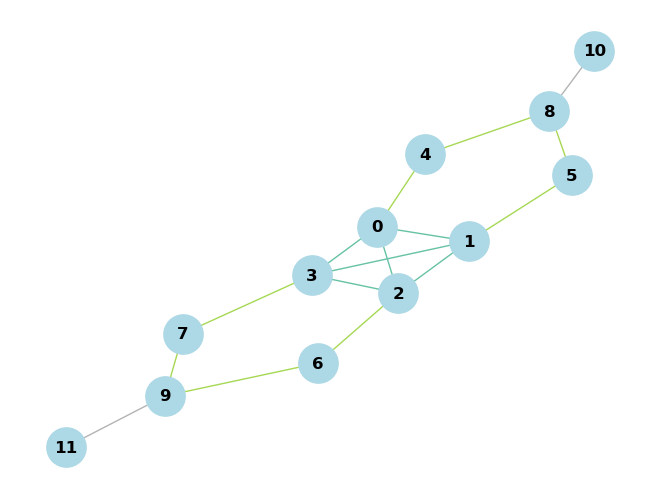

Table (rows: [1/min(eta), m/t, 1/max(eta)]):
[[ 2.       2.       2.       2.       2.28571  2.66667  3.2      4.
   5.33333  8.      16.     ]
 [ 1.45455  1.6      1.77778  2.       2.28571  2.66667  3.2      4.
   5.33333  8.      16.     ]
 [ 1.       1.42857  1.66667  2.       2.28571  2.66667  3.2      4.
   5.33333  8.      16.     ]]


In [12]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a connected, non-regular graph with 6 vertices
G = nx.Graph()

# Add irregular edges within cluster 1
G.add_edges_from([
    (0, 1), (0, 2),(0,3),(1,2),(2,3),(1,3),(0,4),(1,5),(2,6),(3,7),(4,8),(5,8),(6,9),(7,9),(8,10),(9,11)
])



# Visualize the graph
pos = nx.spring_layout(G, seed=42)
# Compute the table
table = compute_eta_table(G)
# Draw the graph
n = len(G.nodes())
A = matrix_forest_size_t(G, n-1)
mod,rho = modul_unweighted(A, 2)
eta = rho/mod
nx.draw(G, with_labels=True, node_color='lightblue', node_size=800, font_weight='bold',edge_color=np.round(rho,2), edge_cmap=plt.cm.Set2)
plt.show()
# Display
print("Table (rows: [1/min(eta), m/t, 1/max(eta)]):")
print(table)

Table (rows: [1/min(eta), m/t, 1/max(eta)]):
[[ 2.       2.       2.       2.       2.28571  2.66667  3.2      4.
   5.33333  8.      16.     ]
 [ 1.45455  1.6      1.77778  2.       2.28571  2.66667  3.2      4.
   5.33333  8.      16.     ]
 [ 1.       1.42857  1.66667  2.       2.28571  2.66667  3.2      4.
   5.33333  8.      16.     ]]


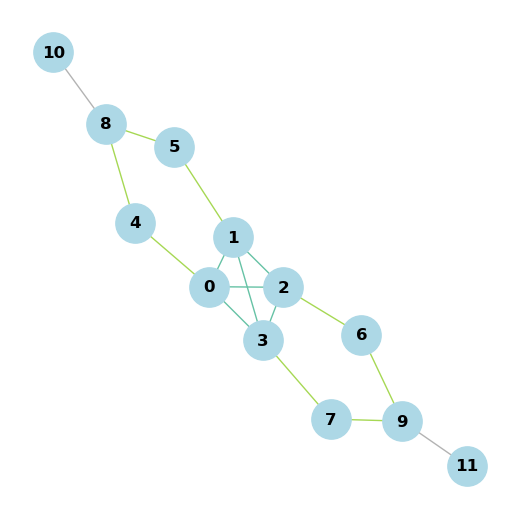

In [13]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a connected, non-regular graph with 6 vertices
G = nx.Graph()

# Add irregular edges within cluster 1
G.add_edges_from([
    (0, 1), (0, 2),(0,3),(1,2),(2,3),(1,3),(0,4),(1,5),(2,6),(3,7),(4,8),(5,8),(6,9),(7,9),(8,10),(9,11)
])
# Visualize the graph
pos = nx.spring_layout(G, seed=42)
# Compute the table
table=compute_eta_table_basic(G)
# Display
print("Table (rows: [1/min(eta), m/t, 1/max(eta)]):")
print(table)
# Draw the graph
mst = MinimumSpanningTree(G)
m =  len(G.edges())
pos= nx.spring_layout(G)
mod, cons, rho, lam = modulus(m, matrix_modulus, mst, max_iter=400)
plt.figure(figsize=(5,5))
nx.draw(G, with_labels=True, node_color='lightblue', node_size=800, font_weight='bold',edge_color=np.round(rho,2), edge_cmap=plt.cm.Set2)
plt.show()

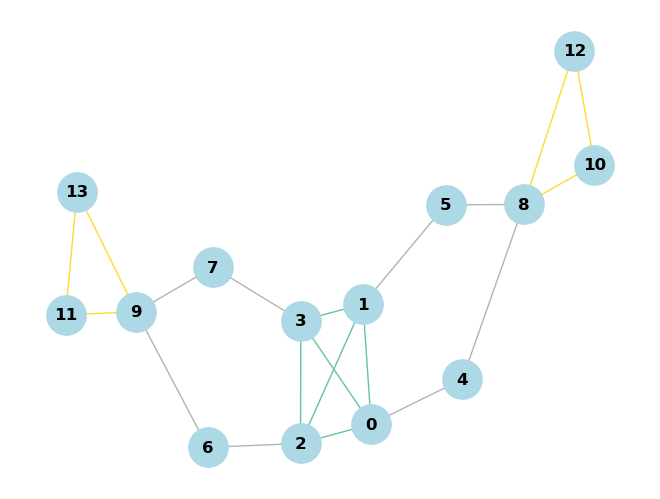

Table (rows: [1/min(eta), m/t, 1/max(eta)]):
[[ 2.       2.       2.0002   2.       2.22242  2.5      2.85714  3.33333
   4.       5.       6.66667 10.      20.     ]
 [ 1.53846  1.66667  1.81818  2.       2.22222  2.5      2.85714  3.33333
   4.       5.       6.66667 10.      20.     ]
 [ 1.33333  1.55556  1.74973  2.       2.22184  2.5      2.85714  3.33333
   4.       5.       6.66667 10.      20.     ]]


In [13]:
#Apr 17

import networkx as nx
import matplotlib.pyplot as plt

# Create a connected, non-regular graph with 6 vertices
G = nx.Graph()

# Add irregular edges within cluster 1
G.add_edges_from([
    (0, 1), (0, 2),(0,3),(1,2),(2,3),(1,3),(0,4),(1,5),(2,6),(3,7),(4,8),(5,8),(6,9),
    (7,9),(8,10),(9,11),(8,12),(9,13),(10,12),(11,13)
])

# Visualize the graph
pos = nx.spring_layout(G, seed=42)
# Compute the table
table = compute_eta_table_basic(G)
# Draw the graph
n = len(G.nodes())
A = matrix_forest_size_t(G, n-1)
mod,rho = modul_unweighted(A, 2)
eta = rho/mod
nx.draw(G, with_labels=True, node_color='lightblue', node_size=800, font_weight='bold',edge_color=np.round(rho,2), edge_cmap=plt.cm.Set2)
plt.show()
# Display
print("Table (rows: [1/min(eta), m/t, 1/max(eta)]):")
print(table)

In [14]:
print_eta_table_manual(table)

t          | 13      | 12      | 11      | 10      | 9       | 8       | 7       | 6       | 5       | 4       | 3       | 2        | 1       
----------------------------------------------------------------------------------------------------------------------------------------------
1/min(eta) | 2.00000 | 2.00000 | 2.00020 | 2.00000 | 2.22242 | 2.50000 | 2.85714 | 3.33333 | 4.00000 | 5.00000 | 6.66667 | 10.00000 | 20.00000
m/t        | 1.53846 | 1.66667 | 1.81818 | 2.00000 | 2.22222 | 2.50000 | 2.85714 | 3.33333 | 4.00000 | 5.00000 | 6.66667 | 10.00000 | 20.00000
1/max(eta) | 1.33333 | 1.55556 | 1.74973 | 2.00000 | 2.22184 | 2.50000 | 2.85714 | 3.33333 | 4.00000 | 5.00000 | 6.66667 | 10.00000 | 20.00000


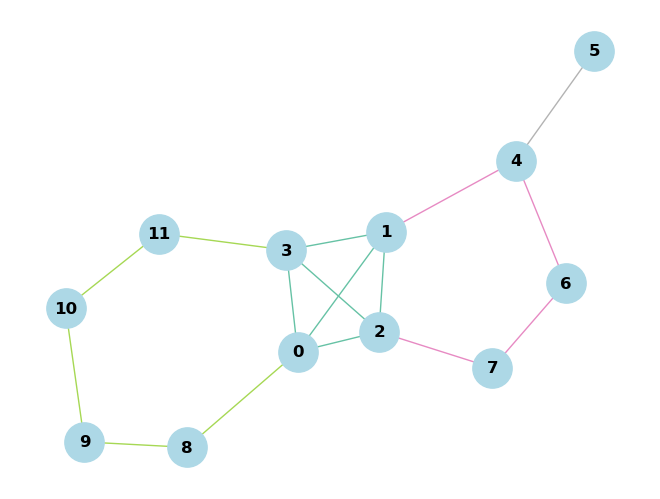

Table (rows: [1/min(eta), m/t, 1/max(eta)]):
t          | 11      | 10      | 9       | 8       | 7       | 6       | 5       | 4       | 3       | 2       | 1       
-------------------------------------------------------------------------------------------------------------------------
1/min(eta) | 2.00000 | 2.00000 | 2.00000 | 2.00000 | 2.28571 | 2.66667 | 3.20000 | 4.00000 | 5.33333 | 8.00000 | 16.00000
m/t        | 1.45455 | 1.60000 | 1.77778 | 2.00000 | 2.28571 | 2.66667 | 3.20000 | 4.00000 | 5.33333 | 8.00000 | 16.00000
1/max(eta) | 1.00000 | 1.42857 | 1.66667 | 2.00000 | 2.28571 | 2.66667 | 3.20000 | 4.00000 | 5.33333 | 8.00000 | 16.00000


In [15]:
#Apr 17

import networkx as nx
import matplotlib.pyplot as plt

# Create a connected, non-regular graph with 6 vertices
G = nx.Graph()

# Add irregular edges within cluster 1
G.add_edges_from([
    (0, 1), (0, 2),(0,3),(1,2),(2,3),(1,3),(1,4),(4,5),(4,6),(6,7),(7,2),(0,8),(8,9),(9,10),(10,11),(11,3)
])

# Visualize the graph
pos = nx.spring_layout(G, seed=42)
# Compute the table
table = compute_eta_table_basic(G)
# Draw the graph
n = len(G.nodes())
A = matrix_forest_size_t(G, n-1)
mod,rho = modul_unweighted(A, 2)
eta = rho/mod
nx.draw(G, with_labels=True, node_color='lightblue', node_size=800, font_weight='bold',edge_color=np.round(rho,2), edge_cmap=plt.cm.Set2)
plt.show()
# Display
print("Table (rows: [1/min(eta), m/t, 1/max(eta)]):")
print_eta_table_manual(table)

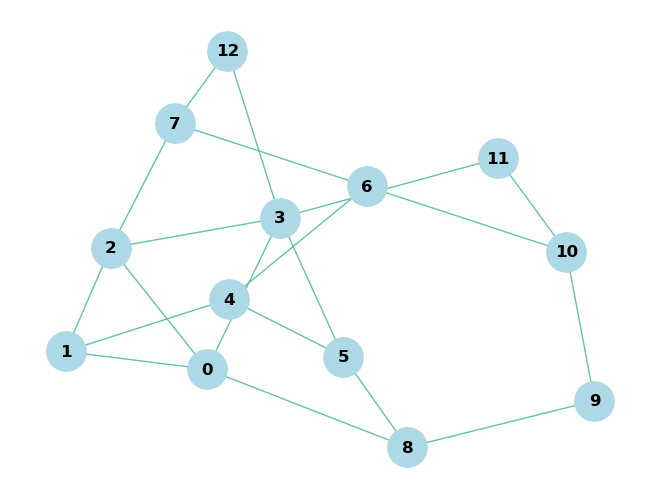

Table (rows: [1/min(eta), m/t, 1/max(eta)]):
t          | 12      | 11      | 10      | 9       | 8       | 7       | 6       | 5       | 4       | 3       | 2        | 1       
------------------------------------------------------------------------------------------------------------------------------------
1/min(eta) | 1.66770 | 1.81818 | 2.00000 | 2.22222 | 2.50000 | 2.85714 | 3.33333 | 4.00000 | 5.00000 | 6.66667 | 10.00000 | 20.00000
m/t        | 1.66667 | 1.81818 | 2.00000 | 2.22222 | 2.50000 | 2.85714 | 3.33333 | 4.00000 | 5.00000 | 6.66667 | 10.00000 | 20.00000
1/max(eta) | 1.66592 | 1.81818 | 2.00000 | 2.22222 | 2.50000 | 2.85714 | 3.33333 | 4.00000 | 5.00000 | 6.66667 | 10.00000 | 20.00000
20
13
[0.59963475 0.59969182 0.59969605 0.60002367 0.59962788 0.59993754
 0.59977373 0.60019436 0.60014891 0.60019119 0.59998404 0.59991059
 0.60006331 0.60006489 0.6001246  0.60026939 0.60025407 0.60016582
 0.60005908 0.60018432]


In [16]:
#Apr 17

import networkx as nx
import matplotlib.pyplot as plt

# Create a connected, non-regular graph with 6 vertices
G = nx.Graph()

# Add irregular edges within cluster 1
G.add_edges_from([
    (0, 1), (0, 2),(0,3),(1,2),(2,3),(1,4),(4,5),(4,6),(6,7),(7,2),(0,8),(8,9),(9,10),(10,11),(11,3),(8,5),(10,6),(3,12),(12,7),(5,3)
])

# Visualize the graph
pos = nx.spring_layout(G, seed=42)
# Compute the table
table = compute_eta_table_basic(G)
# Draw the graph
n = len(G.nodes())
m=len(G.edges())
mst = MinimumTEdgeForest(G, n-1)
mod, cons, rho, lam = modulus(m, matrix_modulus, mst,tol = 1e-4, max_iter=1000)
eta = rho / mod
nx.draw(G, with_labels=True, node_color='lightblue', node_size=800, font_weight='bold',edge_color=np.round(rho,3), edge_cmap=plt.cm.Set2)
plt.show()
# Display
print("Table (rows: [1/min(eta), m/t, 1/max(eta)]):")
print_eta_table_manual(table)
print(m)
print(n)
print(eta)

In [15]:
def print_eta_table_manual_eta(table):
    rows = [[f"{x:.3f}" for x in row] for row in table]

    # Compute the max width for each column
    col_widths = [max(len(row[i]) for row in rows) for i in range(len(rows[0]))]
    row_format = " | ".join([f"{{:<{w}}}" for w in col_widths])

    for row in rows:
        print(row_format.format(*row))


In [ ]:
## end here
# next, compute table with all eta
#compute_eta_table_basic_eta

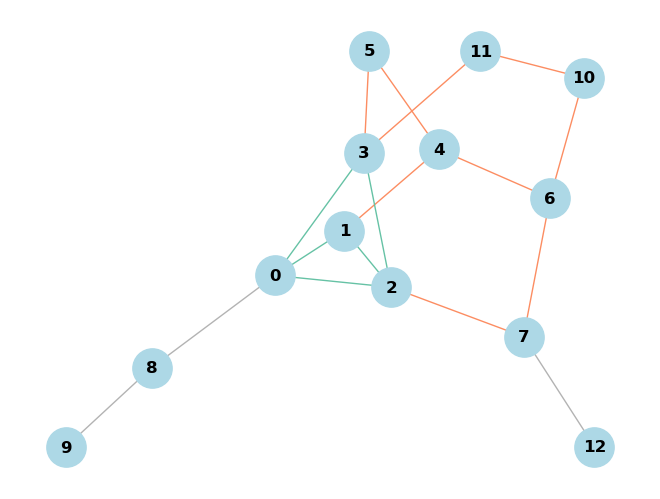

Table (rows: [1/min(eta), m/t, 1/max(eta)]):


NameError: name 'print_eta_table_manual_eta' is not defined

In [13]:
#Apr 17
#print eta

import networkx as nx
import matplotlib.pyplot as plt

# Create a connected, non-regular graph with 6 vertices
G = nx.Graph()

# Add irregular edges within cluster 1
G.add_edges_from([
    (0, 1), (0, 2),(0,3),(1,2),(2,3),(1,4),(4,5),(4,6),(6,7),(7,2),(0,8),(8,9),(10,11),(11,3),(10,6),(12,7),(5,3)
])

# Visualize the graph
pos = nx.spring_layout(G, seed=42)
# Compute the table
table = compute_eta_table_basic_eta(G)
# Draw the graph
n = len(G.nodes())
m=len(G.edges())
mst = MinimumTEdgeForest(G, n-1)
mod, cons, rho, lam = modulus(m, matrix_modulus, mst, tol = 1e-4,max_iter=1000)
eta = rho / mod
nx.draw(G, with_labels=True, node_color='lightblue', node_size=800, font_weight='bold',edge_color=np.round(rho,3), edge_cmap=plt.cm.Set2)
plt.show()
# Display
print("Table (rows: [1/min(eta), m/t, 1/max(eta)]):")
print_eta_table_manual_eta(table)
print(m)
print(n)
print(1/eta)


In [ ]:
#Apr 17
#print eta

import networkx as nx
import matplotlib.pyplot as plt

# Create a connected, non-regular graph with 6 vertices
G = nx.Graph()

# Add irregular edges within cluster 1
G.add_edges_from([
    (0, 1), (0, 2),(0,3),(1,2),(2,3),(1,4),(4,5),(4,6),(6,7),(7,2),(0,8),(8,1)
])

# Visualize the graph
pos = nx.spring_layout(G, seed=42)
# Compute the table
table = compute_eta_table_basic_eta(G)
# Draw the graph
n = len(G.nodes())
m=len(G.edges())
mst = MinimumTEdgeForest(G, n-1)
mod, cons, rho, lam = modulus(m, matrix_modulus, mst,tol = 1e-3, max_iter=1000)
eta = rho / mod
nx.draw(G, with_labels=True, node_color='lightblue', node_size=800, font_weight='bold',edge_color=np.round(rho,3), edge_cmap=plt.cm.Set2)
plt.show()
# Display
print("Table (rows: [1/min(eta), m/t, 1/max(eta)]):")
print_eta_table_manual_eta(table)
print(m)
print(n)
print(1/eta)


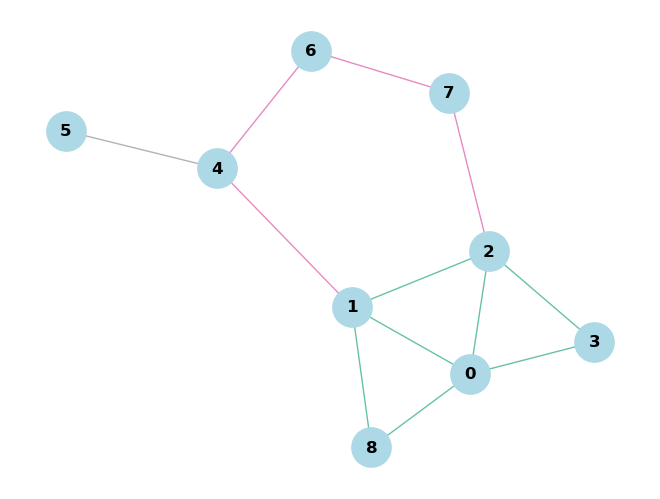

Table (rows: [1/min(eta), m/t, 1/max(eta)]):
0.571 | 0.571 | 0.500 | 0.417 | 0.333 | 0.250 | 0.167 | 0.083
0.571 | 0.571 | 0.500 | 0.417 | 0.333 | 0.250 | 0.167 | 0.083
0.571 | 0.571 | 0.500 | 0.417 | 0.333 | 0.250 | 0.167 | 0.083
0.571 | 0.571 | 0.500 | 0.417 | 0.333 | 0.250 | 0.167 | 0.083
0.571 | 0.571 | 0.500 | 0.417 | 0.333 | 0.250 | 0.167 | 0.083
0.571 | 0.571 | 0.500 | 0.417 | 0.333 | 0.250 | 0.167 | 0.083
0.571 | 0.571 | 0.500 | 0.417 | 0.333 | 0.250 | 0.167 | 0.083
0.750 | 0.600 | 0.500 | 0.417 | 0.333 | 0.250 | 0.167 | 0.083
0.750 | 0.600 | 0.500 | 0.417 | 0.333 | 0.250 | 0.167 | 0.083
0.750 | 0.600 | 0.500 | 0.417 | 0.333 | 0.250 | 0.167 | 0.083
0.750 | 0.600 | 0.500 | 0.417 | 0.333 | 0.250 | 0.167 | 0.083
1.000 | 0.600 | 0.500 | 0.417 | 0.333 | 0.250 | 0.167 | 0.083
12
9
[1.75092937 1.7552795  1.74876238 1.74444444 1.75310174 1.33176249
 1.74014778 1.75746269 1.33427762 1.         1.33427762 1.33301887]


In [17]:
#Apr 17
#print eta

import networkx as nx
import matplotlib.pyplot as plt

# Create a connected, non-regular graph with 6 vertices
G = nx.Graph()

# Add irregular edges within cluster 1
G.add_edges_from([
    (0, 1), (0, 2),(0,3),(1,2),(2,3),(1,4),(4,5),(4,6),(6,7),(7,2),(0,8),(8,1)
])

# Visualize the graph
pos = nx.spring_layout(G, seed=42)
# Compute the table
table = compute_eta_table_sorted(G)
# Draw the graph
n = len(G.nodes())
m=len(G.edges())
mst = MinimumTEdgeForest(G, n-1)
mod, cons, rho, lam = modulus(m, matrix_modulus, mst,tol = 1e-3, max_iter=1000)
eta = rho / mod
nx.draw(G, with_labels=True, node_color='lightblue', node_size=800, font_weight='bold',edge_color=np.round(rho,3), edge_cmap=plt.cm.Set2)
plt.show()
# Display
print("Table (rows: [1/min(eta), m/t, 1/max(eta)]):")
print_eta_table_manual_eta(table)
print(m)
print(n)
print(1/eta)



In [ ]:
#DO SAME BUT SORT ETA compute_eta_table_sorted(G)

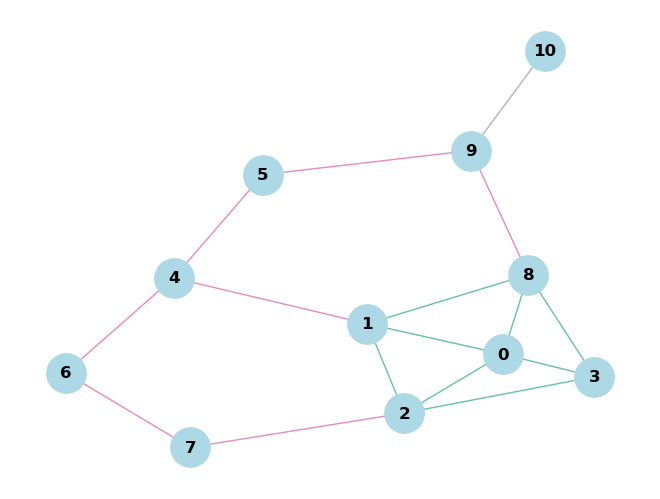

Table (rows: [1/min(eta), m/t, 1/max(eta)]):
0.500 | 0.500 | 0.500 | 0.438 | 0.375 | 0.312 | 0.250 | 0.188 | 0.125 | 0.062
0.500 | 0.500 | 0.500 | 0.438 | 0.375 | 0.312 | 0.250 | 0.188 | 0.125 | 0.062
0.500 | 0.500 | 0.500 | 0.438 | 0.375 | 0.312 | 0.250 | 0.188 | 0.125 | 0.062
0.500 | 0.500 | 0.500 | 0.438 | 0.375 | 0.312 | 0.250 | 0.188 | 0.125 | 0.062
0.500 | 0.500 | 0.500 | 0.438 | 0.375 | 0.312 | 0.250 | 0.188 | 0.125 | 0.062
0.500 | 0.500 | 0.500 | 0.438 | 0.375 | 0.312 | 0.250 | 0.188 | 0.125 | 0.062
0.500 | 0.500 | 0.500 | 0.438 | 0.375 | 0.312 | 0.250 | 0.188 | 0.125 | 0.062
0.500 | 0.500 | 0.500 | 0.438 | 0.375 | 0.312 | 0.250 | 0.188 | 0.125 | 0.062
0.714 | 0.625 | 0.500 | 0.438 | 0.375 | 0.312 | 0.250 | 0.188 | 0.125 | 0.062
0.714 | 0.625 | 0.500 | 0.438 | 0.375 | 0.312 | 0.250 | 0.188 | 0.125 | 0.062
0.714 | 0.625 | 0.500 | 0.438 | 0.375 | 0.312 | 0.250 | 0.188 | 0.125 | 0.062
0.714 | 0.625 | 0.500 | 0.438 | 0.375 | 0.312 | 0.250 | 0.188 | 0.125 | 0.062
0.714 | 0.625 | 0.5

In [18]:
#Apr 17
#print eta

import networkx as nx
import matplotlib.pyplot as plt

# Create a connected, non-regular graph with 6 vertices
G = nx.Graph()

# Add irregular edges within cluster 1
G.add_edges_from([
    (0, 1), (0, 2),(0,3),(1,2),(2,3),(1,4),(4,5),(4,6),(6,7),(7,2),(0,8),(8,1),(3,8),(8,9),(9,5),(9,10)
])

# Visualize the graph
pos = nx.spring_layout(G, seed=42)
# Compute the table
table = compute_eta_table_sorted(G)
# Draw the graph
n = len(G.nodes())
m=len(G.edges())
mst = MinimumTEdgeForest(G, n-1)
mod, cons, rho, lam = modulus(m, matrix_modulus, mst,tol = 1e-3, max_iter=1000)
eta = rho / mod
nx.draw(G, with_labels=True, node_color='lightblue', node_size=800, font_weight='bold',edge_color=np.round(rho,3), edge_cmap=plt.cm.Set2)
plt.show()
# Display
print("Table (rows: [1/min(eta), m/t, 1/max(eta)]):")
print_eta_table_manual_eta(table)
print(m)
print(n)
print(1/eta)



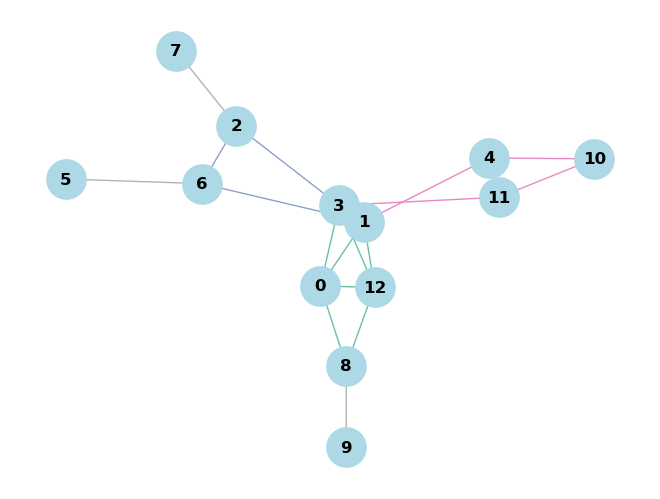

Table (rows: [1/min(eta), m/t, 1/max(eta)]):
0.500 | 0.500 | 0.500 | 0.500 | 0.444 | 0.389 | 0.333 | 0.278 | 0.222 | 0.167 | 0.111 | 0.056
0.500 | 0.500 | 0.500 | 0.500 | 0.444 | 0.389 | 0.333 | 0.278 | 0.222 | 0.167 | 0.111 | 0.056
0.500 | 0.500 | 0.500 | 0.500 | 0.444 | 0.389 | 0.333 | 0.278 | 0.222 | 0.167 | 0.111 | 0.056
0.500 | 0.500 | 0.500 | 0.500 | 0.444 | 0.389 | 0.333 | 0.278 | 0.222 | 0.167 | 0.111 | 0.056
0.500 | 0.500 | 0.500 | 0.500 | 0.444 | 0.389 | 0.333 | 0.278 | 0.222 | 0.167 | 0.111 | 0.056
0.500 | 0.500 | 0.500 | 0.500 | 0.444 | 0.389 | 0.333 | 0.278 | 0.222 | 0.167 | 0.111 | 0.056
0.500 | 0.500 | 0.500 | 0.500 | 0.444 | 0.389 | 0.333 | 0.278 | 0.222 | 0.167 | 0.111 | 0.056
0.500 | 0.500 | 0.500 | 0.500 | 0.444 | 0.389 | 0.333 | 0.278 | 0.222 | 0.167 | 0.111 | 0.056
0.667 | 0.667 | 0.600 | 0.500 | 0.444 | 0.389 | 0.333 | 0.278 | 0.222 | 0.167 | 0.111 | 0.056
0.667 | 0.667 | 0.600 | 0.500 | 0.444 | 0.389 | 0.333 | 0.278 | 0.222 | 0.167 | 0.111 | 0.056
0.667 | 0.667 |

In [22]:

#Apr 17
#print eta

import networkx as nx
import matplotlib.pyplot as plt

# Create a connected, non-regular graph with 6 vertices
G = nx.Graph()

# Add irregular edges within cluster 1
G.add_edges_from([
    (0, 1), (0,3),(2,3),(1,4),(7,2),(0,8),(8,9),(10,11),(11,3),
    (3,12),(8,12),(4,10),(5,6),(1,3),(6,2),(6,1),(0,12),(1,12)
])
# Visualize the graph
pos = nx.spring_layout(G, seed=42)
# Compute the table
table = compute_eta_table_sorted(G)
# Draw the graph
n = len(G.nodes())
m=len(G.edges())
mst = MinimumTEdgeForest(G, n-1)
mod, cons, rho, lam = modulus(m, matrix_modulus, mst,tol = 1e-5, max_iter=1000)
eta = rho / mod
nx.draw(G, pos,with_labels=True, node_color='lightblue', node_size=800, font_weight='bold',edge_color=np.round(rho,3), edge_cmap=plt.cm.Set2)
plt.show()
# Display
print("Table (rows: [1/min(eta), m/t, 1/max(eta)]):")
print_eta_table_manual_eta(table)
print(m)
print(n)
print(1/eta)



In [ ]:
#SORTED WITH INDEX TABLE TO FIND EDGES, NOT IMPORTANT LATER, compute_eta_table_sorted_with_index_table

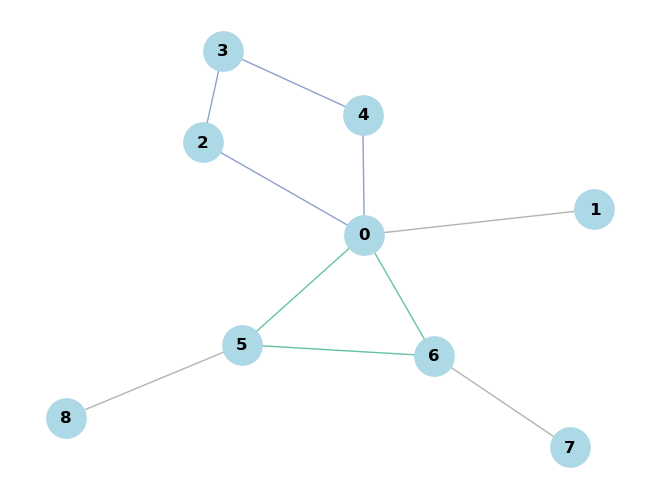

Table (rows: [1/min(eta), m/t, 1/max(eta)]):
(array([[0.667, 0.667, 0.6  , 0.5  , 0.4  , 0.3  , 0.2  , 0.1  ],
       [0.667, 0.667, 0.6  , 0.5  , 0.4  , 0.3  , 0.2  , 0.1  ],
       [0.667, 0.667, 0.6  , 0.5  , 0.4  , 0.3  , 0.2  , 0.1  ],
       [0.75 , 0.714, 0.6  , 0.5  , 0.4  , 0.3  , 0.2  , 0.1  ],
       [0.75 , 0.714, 0.6  , 0.5  , 0.4  , 0.3  , 0.2  , 0.1  ],
       [0.75 , 0.714, 0.6  , 0.5  , 0.4  , 0.3  , 0.2  , 0.1  ],
       [0.75 , 0.714, 0.6  , 0.5  , 0.4  , 0.3  , 0.2  , 0.1  ],
       [1.   , 0.714, 0.6  , 0.5  , 0.4  , 0.3  , 0.2  , 0.1  ],
       [1.   , 0.714, 0.6  , 0.5  , 0.4  , 0.3  , 0.2  , 0.1  ],
       [1.   , 0.714, 0.6  , 0.5  , 0.4  , 0.3  , 0.2  , 0.1  ]]), array([[3, 3, 0, 0, 0, 0, 0, 0],
       [4, 4, 1, 1, 1, 1, 1, 1],
       [7, 7, 2, 2, 2, 2, 2, 2],
       [1, 0, 3, 3, 3, 3, 3, 3],
       [2, 1, 4, 4, 4, 4, 4, 4],
       [5, 2, 5, 5, 5, 5, 5, 5],
       [6, 5, 6, 6, 6, 6, 6, 6],
       [0, 6, 7, 7, 7, 7, 7, 7],
       [8, 8, 8, 8, 8, 8, 8, 8],
     

In [18]:

#Apr 19, shrink
#print eta

import networkx as nx
import matplotlib.pyplot as plt

# Create a connected, non-regular graph with 6 vertices
G = nx.Graph()

# Add irregular edges within cluster 1
G.add_edges_from([
    (0, 1), (0,2),(2,3),(3,4),(4,0),(0,5),(5,6),(6,0),(6,7),(5,8)
])
# Visualize the graph
pos = nx.spring_layout(G, seed=42)
# Compute the table
table = compute_eta_table_sorted_with_index_table(G)
# Draw the graph
n = len(G.nodes())
m=len(G.edges())
mst = MinimumTEdgeForest(G, n-1)
mod, cons, rho, lam = modulus(m, matrix_modulus, mst,tol = 1e-5, max_iter=1000)
eta = rho / mod
nx.draw(G, pos,with_labels=True, node_color='lightblue', node_size=800, font_weight='bold',edge_color=np.round(rho,3), edge_cmap=plt.cm.Set2)
plt.show()
# Display
print("Table (rows: [1/min(eta), m/t, 1/max(eta)]):")
print(table)
print(m)
print(n)
print(1/eta)



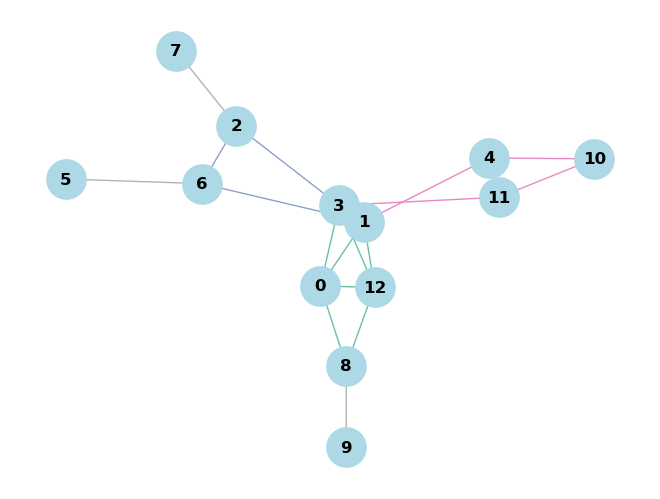

[[0.5   0.5   0.5   0.5   0.444 0.389 0.333 0.278 0.222 0.167 0.111 0.056]
 [0.5   0.5   0.5   0.5   0.444 0.389 0.333 0.278 0.222 0.167 0.111 0.056]
 [0.5   0.5   0.5   0.5   0.444 0.389 0.333 0.278 0.222 0.167 0.111 0.056]
 [0.5   0.5   0.5   0.5   0.444 0.389 0.333 0.278 0.222 0.167 0.111 0.056]
 [0.5   0.5   0.5   0.5   0.444 0.389 0.333 0.278 0.222 0.167 0.111 0.056]
 [0.5   0.5   0.5   0.5   0.444 0.389 0.333 0.278 0.222 0.167 0.111 0.056]
 [0.5   0.5   0.5   0.5   0.444 0.389 0.333 0.278 0.222 0.167 0.111 0.056]
 [0.5   0.5   0.5   0.5   0.444 0.389 0.333 0.278 0.222 0.167 0.111 0.056]
 [0.667 0.667 0.6   0.5   0.444 0.389 0.333 0.278 0.222 0.167 0.111 0.056]
 [0.667 0.667 0.6   0.5   0.444 0.389 0.333 0.278 0.222 0.167 0.111 0.056]
 [0.667 0.667 0.6   0.5   0.444 0.389 0.333 0.278 0.222 0.167 0.111 0.056]
 [0.75  0.714 0.6   0.5   0.444 0.389 0.333 0.278 0.222 0.167 0.111 0.056]
 [0.75  0.714 0.6   0.5   0.444 0.389 0.333 0.278 0.222 0.167 0.111 0.056]
 [0.75  0.714 0.6   0.5  

In [24]:

#Apr 17
#print eta

import networkx as nx
import matplotlib.pyplot as plt

# Create a connected, non-regular graph with 6 vertices
G = nx.Graph()

# Add irregular edges within cluster 1
G.add_edges_from([
    (0, 1), (0,3),(2,3),(1,4),(7,2),(0,8),(8,9),(10,11),(11,3),
    (3,12),(8,12),(4,10),(5,6),(1,3),(6,2),(6,1),(0,12),(1,12)
])
# Visualize the graph
pos = nx.spring_layout(G, seed=42)
# Compute the table
table, index = compute_eta_table_sorted_with_index_table(G)
# Draw the graph
n = len(G.nodes())
m=len(G.edges())
mst = MinimumTEdgeForest(G, n-1)
mod, cons, rho, lam = modulus(m, matrix_modulus, mst,tol = 1e-5, max_iter=1000)
eta = rho / mod
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=800, font_weight='bold',edge_color=np.round(rho,3), edge_cmap=plt.cm.Set2)
plt.show()
# Display
print(table)
print(m)
print(n)
print(index)



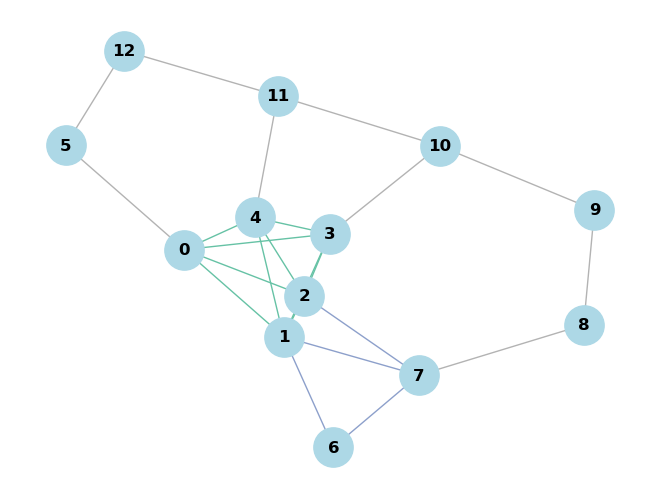

[[0.4   0.4   0.4   0.391 0.348 0.304 0.261 0.217 0.174 0.13  0.087 0.043]
 [0.4   0.4   0.4   0.391 0.348 0.304 0.261 0.217 0.174 0.13  0.087 0.043]
 [0.4   0.4   0.4   0.391 0.348 0.304 0.261 0.217 0.174 0.13  0.087 0.043]
 [0.4   0.4   0.4   0.391 0.348 0.304 0.261 0.217 0.174 0.13  0.087 0.043]
 [0.4   0.4   0.4   0.391 0.348 0.304 0.261 0.217 0.174 0.13  0.087 0.043]
 [0.4   0.4   0.4   0.391 0.348 0.304 0.261 0.217 0.174 0.13  0.087 0.043]
 [0.4   0.4   0.4   0.391 0.348 0.304 0.261 0.217 0.174 0.13  0.087 0.043]
 [0.4   0.4   0.4   0.391 0.348 0.304 0.261 0.217 0.174 0.13  0.087 0.043]
 [0.4   0.4   0.4   0.391 0.348 0.304 0.261 0.217 0.174 0.13  0.087 0.043]
 [0.4   0.4   0.4   0.391 0.348 0.304 0.261 0.217 0.174 0.13  0.087 0.043]
 [0.5   0.5   0.462 0.391 0.348 0.304 0.261 0.217 0.174 0.13  0.087 0.043]
 [0.5   0.5   0.462 0.391 0.348 0.304 0.261 0.217 0.174 0.13  0.087 0.043]
 [0.5   0.5   0.462 0.391 0.348 0.304 0.261 0.217 0.174 0.13  0.087 0.043]
 [0.5   0.5   0.462 0.391

In [25]:

#Apr 17
#print eta

import networkx as nx
import matplotlib.pyplot as plt

# Create a connected, non-regular graph with 6 vertices
G = nx.Graph()

# Add irregular edges within cluster 1
G.add_edges_from([(0,1),(0,2),(0,3),(0,4),(1,2),(1,3),(1,4),(2,3),(2,4),(3,4),(6,7),(7,8),(8,9),(9,10),(10,11),(11,12),(12,5),
                  (0,5),(1,6),(2,7),(3,10),(4,11),(1,7)
])
# Visualize the graph
pos = nx.spring_layout(G, seed=38)
# Compute the table
table, index = compute_eta_table_sorted_with_index_table(G)
# Draw the graph
n = len(G.nodes())
m=len(G.edges())
mst = MinimumTEdgeForest(G, n-1)
mod, cons, rho, lam = modulus(m, matrix_modulus, mst,tol = 1e-5, max_iter=1000)
eta = rho / mod
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=800, font_weight='bold',edge_color=np.round(rho,3), edge_cmap=plt.cm.Set2)
plt.show()
# Display
print(table)
print(m)
print(n)
print(index)



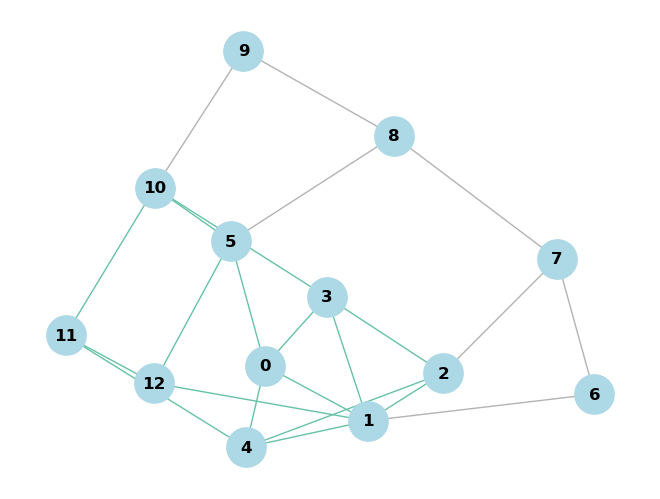

[[0.5   0.478 0.435 0.391 0.348 0.304 0.261 0.217 0.174 0.13  0.087 0.043]
 [0.5   0.478 0.435 0.391 0.348 0.304 0.261 0.217 0.174 0.13  0.087 0.043]
 [0.5   0.478 0.435 0.391 0.348 0.304 0.261 0.217 0.174 0.13  0.087 0.043]
 [0.5   0.478 0.435 0.391 0.348 0.304 0.261 0.217 0.174 0.13  0.087 0.043]
 [0.5   0.478 0.435 0.391 0.348 0.304 0.261 0.217 0.174 0.13  0.087 0.043]
 [0.5   0.478 0.435 0.391 0.348 0.304 0.261 0.217 0.174 0.13  0.087 0.043]
 [0.5   0.478 0.435 0.391 0.348 0.304 0.261 0.217 0.174 0.13  0.087 0.043]
 [0.5   0.478 0.435 0.391 0.348 0.304 0.261 0.217 0.174 0.13  0.087 0.043]
 [0.5   0.478 0.435 0.391 0.348 0.304 0.261 0.217 0.174 0.13  0.087 0.043]
 [0.5   0.478 0.435 0.391 0.348 0.304 0.261 0.217 0.174 0.13  0.087 0.043]
 [0.5   0.478 0.435 0.391 0.348 0.304 0.261 0.217 0.174 0.13  0.087 0.043]
 [0.5   0.478 0.435 0.391 0.348 0.304 0.261 0.217 0.174 0.13  0.087 0.043]
 [0.5   0.478 0.435 0.391 0.348 0.304 0.261 0.217 0.174 0.13  0.087 0.043]
 [0.5   0.478 0.435 0.391

In [26]:

#Apr 17
#print eta

import networkx as nx
import matplotlib.pyplot as plt

# Create a connected, non-regular graph with 6 vertices
G = nx.Graph()

# Add irregular edges within cluster 1
G.add_edges_from([(0,1),(0,3),(0,4),(1,2),(1,3),(1,4),(2,3),(2,4),(5,10),(7,8),(8,9),(9,10),(10,11),(11,12),(12,5),
                  (0,5),(1,6),(2,7),(3,10),(4,11),(12,1),(5,8),(7,6)
])
# Visualize the graph
pos = nx.spring_layout(G, seed=38)
# Compute the table
table, index = compute_eta_table_sorted_with_index_table(G)
# Draw the graph
n = len(G.nodes())
m=len(G.edges())
mst = MinimumTEdgeForest(G, n-1)
mod, cons, rho, lam = modulus(m, matrix_modulus, mst,tol = 1e-5, max_iter=1000)
eta = rho / mod
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=800, font_weight='bold',edge_color=np.round(rho,3), edge_cmap=plt.cm.Set2)
plt.show()
# Display
print(table)
print(m)
print(n)
print(index)



[0.47825912 0.4782603  0.47826484 0.47826481 0.4782611  0.47825559
 0.47826136 0.47826767 0.47825122 0.47826376 0.47826654 0.47826662
 0.47826087 0.47825168 0.47826027 0.47826379 0.47826142 0.47827035
 0.47825797 0.47825693 0.47826345 0.47825698 0.47825336]


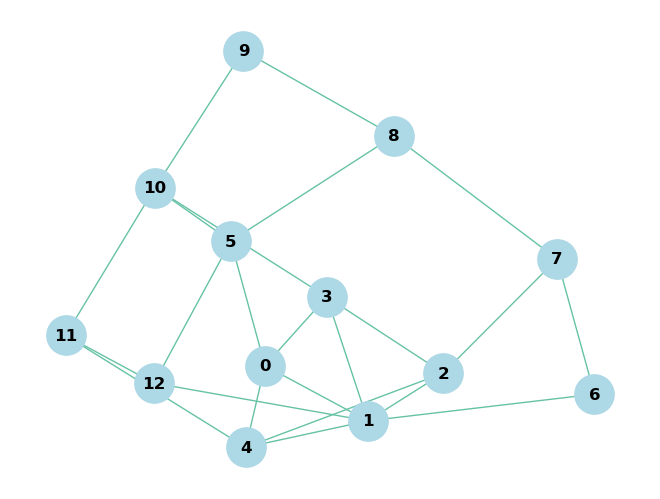

In [27]:
mst = MinimumTEdgeForest(G, n-2)
mod, cons, rho, lam = modulus(m, matrix_modulus, mst,tol = 1e-5, max_iter=1000)
eta = rho / mod
print(eta)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=800, font_weight='bold',edge_color=np.round(rho,3), edge_cmap=plt.cm.Set2)
plt.show()

[0.4347806  0.43478481 0.43478362 0.43478564 0.43478126 0.43478208
 0.43478202 0.43478216 0.43477972 0.43478216 0.43478172 0.43478583
 0.43478314 0.43478343 0.43478578 0.43478264 0.43477993 0.4347825
 0.43478095 0.43478319 0.43478482 0.43478126 0.43478073]


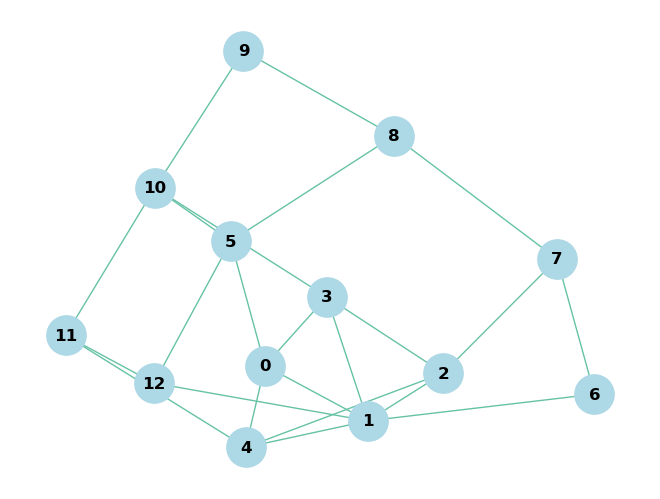

In [28]:
mst = MinimumTEdgeForest(G, n-3)
mod, cons, rho, lam = modulus(m, matrix_modulus, mst,tol = 1e-5, max_iter=1000)
eta = rho / mod
print(eta)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=800, font_weight='bold',edge_color=np.round(rho,3), edge_cmap=plt.cm.Set2)
plt.show()


[0.39130435 0.39130435 0.39130435 0.39130435 0.39130435 0.39130435
 0.39130435 0.39130435 0.39130435 0.39130435 0.39130435 0.39130435
 0.39130435 0.39130435 0.39130435 0.39130435 0.39130435 0.39130435
 0.39130435 0.39130435 0.39130435 0.39130435 0.39130435]


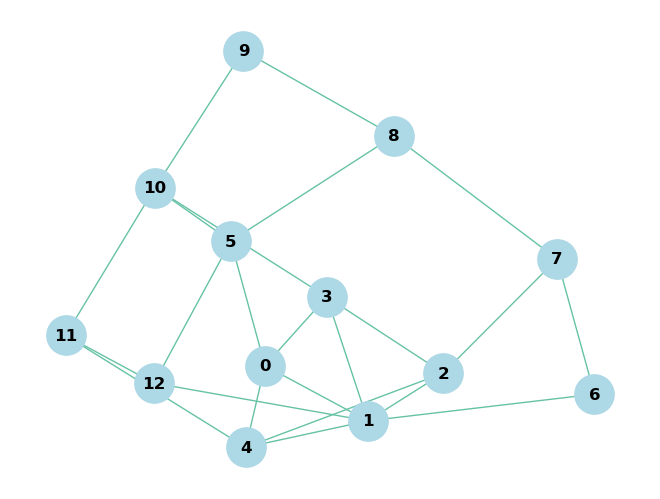

In [29]:
mst = MinimumTEdgeForest(G, n-4)
mod, cons, rho, lam = modulus(m, matrix_modulus, mst,tol = 1e-5, max_iter=1000)
eta = rho / mod
print(eta)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=800, font_weight='bold',edge_color=np.round(rho,3), edge_cmap=plt.cm.Set2)
plt.show()


In [ ]:
# DOING SOME TESTS NEXT, NEED TO CLARIFY HERE

In [ ]:
import networkx as nx
import numpy as np
from itertools import combinations

def test_eta_property_fast(G):
    num_nodes = len(G.nodes)
    num_edges = len(G.edges)

    min_etas_before_t0 = []

    for t_index, t in enumerate(range(1, num_nodes)):
        forest = MinimumTEdgeForest(G, num_nodes - t)
        mod, cons, rho, lam = modulus(num_edges, matrix_modulus, forest, tol=1e-4, max_iter=1000)
        eta = rho / mod
        min_eta = np.round(np.min(eta), 3)
        max_eta = np.round(np.max(eta), 3)

        if min_eta == max_eta:
            if len(set(min_etas_before_t0)) >= 2:
                print("✅ Valid graph found!")
                print("Edges:", list(G.edges()))
                # Now recompute the whole eta table only once for printing
                full_table = compute_eta_table_sorted(G)
                print("Eta Table:")
                print(full_table)
                return True
            else:
                return False
        else:
            min_etas_before_t0.append(min_eta)

    return False  # No t₀ where min == max found

# Generate all connected graphs with n nodes and m edges
def all_connected_graphs(n, m):
    nodes = list(range(n))
    all_possible_edges = list(combinations(nodes, 2))
    for edges in combinations(all_possible_edges, m):
        G = nx.Graph()
        G.add_edges_from(edges)
        if nx.is_connected(G):
            yield G

# Main search loop
n, m = 7, 14  # Small size for tractability
found = False
for G in all_connected_graphs(n, m):
    if test_eta_property_fast(G):
        found = True
        break

if not found:
    print("❌ No valid graph found with the condition.")


In [13]:
import networkx as nx
import numpy as np
from itertools import combinations

def detect_eta_collapse_condition(G):
    num_nodes = len(G.nodes)
    num_edges = len(G.edges)

    previous_eta_vectors = []

    for t_index, t in enumerate(range(1, num_nodes)):
        forest = MinimumTEdgeForest(G, num_nodes - t)
        mod, cons, rho, lam = modulus(num_edges, matrix_modulus, forest, tol=1e-4, max_iter=1000)
        eta_vector = np.round(rho / mod, 3)

        if np.min(eta_vector) == np.max(eta_vector):
            if t_index >= 1:
                eta_before_collapse = previous_eta_vectors[-1]
                if len(set(eta_before_collapse)) >= 3:
                    print("✅ Interesting graph detected!")
                    print("Edges:", list(G.edges()))
                    full_eta_table = compute_eta_table_sorted(G)
                    print("Eta Table:")
                    print(full_eta_table)
                    return True
            return False
        else:
            previous_eta_vectors.append(eta_vector)

    return False

def generate_connected_graphs(n, m):
    nodes = list(range(n))
    all_possible_edges = list(combinations(nodes, 2))
    for edges in combinations(all_possible_edges, m):
        G = nx.Graph()
        G.add_edges_from(edges)
        if nx.is_connected(G):
            yield G

# Search parameters
num_vertices, num_edges = 7, 12
found_interesting_graph = False

for candidate_graph in generate_connected_graphs(num_vertices, num_edges):
    if detect_eta_collapse_condition(candidate_graph):
        found_interesting_graph = True
        break

if not found_interesting_graph:
    print("❌ No graph matched the condition.")


✅ Interesting graph detected!
Edges: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 2), (1, 3), (1, 4), (1, 5), (2, 3), (2, 4)]
Eta Table:
[[0.44444 0.41667 0.33333 0.25    0.16667 0.08333]
 [0.44444 0.41667 0.33333 0.25    0.16667 0.08333]
 [0.44444 0.41667 0.33333 0.25    0.16667 0.08333]
 [0.44444 0.41667 0.33333 0.25    0.16667 0.08333]
 [0.44444 0.41667 0.33333 0.25    0.16667 0.08333]
 [0.44444 0.41667 0.33333 0.25    0.16667 0.08333]
 [0.44444 0.41667 0.33333 0.25    0.16667 0.08333]
 [0.44444 0.41667 0.33333 0.25    0.16667 0.08333]
 [0.44444 0.41667 0.33333 0.25    0.16667 0.08333]
 [0.5     0.41667 0.33333 0.25    0.16667 0.08333]
 [0.5     0.41667 0.33333 0.25    0.16667 0.08333]
 [1.      0.41667 0.33333 0.25    0.16667 0.08333]]


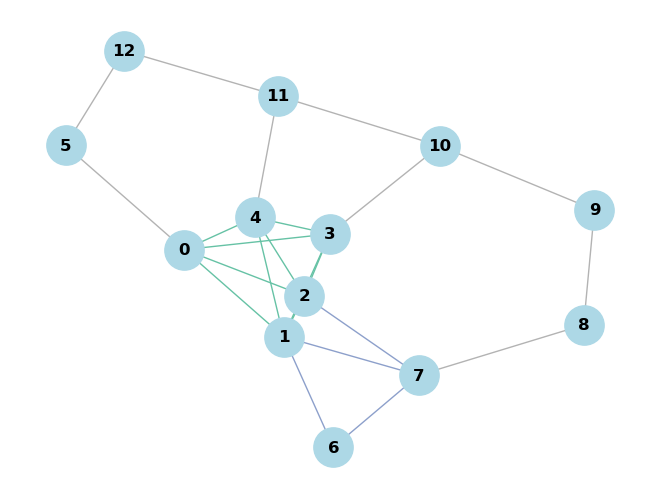

[[0.4   0.4   0.4   0.391 0.348 0.304 0.261 0.217 0.174 0.13  0.087 0.043]
 [0.4   0.4   0.4   0.391 0.348 0.304 0.261 0.217 0.174 0.13  0.087 0.043]
 [0.4   0.4   0.4   0.391 0.348 0.304 0.261 0.217 0.174 0.13  0.087 0.043]
 [0.4   0.4   0.4   0.391 0.348 0.304 0.261 0.217 0.174 0.13  0.087 0.043]
 [0.4   0.4   0.4   0.391 0.348 0.304 0.261 0.217 0.174 0.13  0.087 0.043]
 [0.4   0.4   0.4   0.391 0.348 0.304 0.261 0.217 0.174 0.13  0.087 0.043]
 [0.4   0.4   0.4   0.391 0.348 0.304 0.261 0.217 0.174 0.13  0.087 0.043]
 [0.4   0.4   0.4   0.391 0.348 0.304 0.261 0.217 0.174 0.13  0.087 0.043]
 [0.4   0.4   0.4   0.391 0.348 0.304 0.261 0.217 0.174 0.13  0.087 0.043]
 [0.4   0.4   0.4   0.391 0.348 0.304 0.261 0.217 0.174 0.13  0.087 0.043]
 [0.5   0.5   0.462 0.391 0.348 0.304 0.261 0.217 0.174 0.13  0.087 0.043]
 [0.5   0.5   0.462 0.391 0.348 0.304 0.261 0.217 0.174 0.13  0.087 0.043]
 [0.5   0.5   0.462 0.391 0.348 0.304 0.261 0.217 0.174 0.13  0.087 0.043]
 [0.5   0.5   0.462 0.391

In [17]:


#Apr 17
#print eta

import networkx as nx
import matplotlib.pyplot as plt

# Create a connected, non-regular graph with 6 vertices
G = nx.Graph()

# Add irregular edges within cluster 1
G.add_edges_from([(0,1),(0,2),(0,3),(0,4),(1,2),(1,3),(1,4),(2,3),(2,4),(3,4),(6,7),(7,8),(8,9),(9,10),(10,11),(11,12),(12,5),
                  (0,5),(1,6),(2,7),(3,10),(4,11),(1,7)
])
# Visualize the graph
pos = nx.spring_layout(G, seed=38)
# Compute the table
table, index = compute_eta_table_sorted_with_index_table(G)
# Draw the graph
n = len(G.nodes())
m=len(G.edges())
mst = MinimumTEdgeForest(G, n-1)
mod, cons, rho, lam = modulus(m, matrix_modulus, mst,tol = 1e-5, max_iter=1000)
eta = rho / mod
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=800, font_weight='bold',edge_color=np.round(rho,3), edge_cmap=plt.cm.Set2)
plt.show()
# Display
print(table)
print(m)
print(n)
print(index)




In [ ]:
#NEXT # algorithm to use the matrix from eta^* compute_balancity_and_eta_star(eta):

In [14]:
import numpy as np
from math import floor
import pandas as pd
import numpy as np

def print_eta_star_table(eta_star_matrix):
    k, max_j = eta_star_matrix.shape

    # Create row and column labels
    row_labels = [f"i={i}" for i in range(k)]
    col_labels = [f"j={j}" for j in range(max_j)]

    # Round values and create DataFrame
    df = pd.DataFrame(np.round(eta_star_matrix, 4), index=row_labels, columns=col_labels)

    # Print
    print("\nη*_{i,j} Table:")
    print(df.to_string(index=True))

def compute_balancity_and_eta_star(eta):
    eta = np.array(eta)
    E = np.arange(len(eta))

    # Step 1: Sort and extract unique eta values
    unique_eta = np.sort(np.unique(eta))
    k = len(unique_eta)

    # Step 2: Create A_i and E_i sets
    A = []  # A[i] = set of edges with eta = eta_i^*
    E_sets = []  # E[i] = set of edges with eta >= eta_i^*
    for i in range(k):
        eta_i_star = unique_eta[i]
        A_i = E[eta == eta_i_star]
        E_i = E[eta >= eta_i_star]
        A.append(A_i)
        E_sets.append(E_i)

    # Step 3: Compute b_i and c_i
    b = []
    c = [0]

    for i in range(k):
        eta_i_star = unique_eta[i]
        b_i = floor(len(E_sets[i]) * eta_i_star)
        b.append(b_i)

        if i == 0:
            c.append(b_i)
        else:
            eta_sum = sum(len(A[j]) * unique_eta[j] for j in range(i))
            c_i = b_i + np.round(eta_sum,0)
            c.append(c_i)

    # Step 4: Compute eta^*_{i,j} with new formula
    max_j = int(np.ceil(c[-1])) + 1
    eta_star_matrix = np.zeros((k, max_j))

    for i in range(k):
        for j in range(1, max_j):
            assigned = False
            for l in range(1, k + 1):
                if c[l-1] < j <= c[l] and i >= l - 1:
                    E_l_size = len(E_sets[l-1])
                    if E_l_size > 0:
                        eta_star_matrix[i][j] = (j - (c[l] - b[l-1])) / E_l_size
                    else:
                        eta_star_matrix[i][j] = 0  # or np.nan
                    assigned = True
                    break
            if not assigned:
                eta_star_matrix[i][j] = unique_eta[i]

    print_eta_star_table(np.round(eta_star_matrix,3))
    return {
        "unique_eta": unique_eta,
        "A_sets": A,
        "E_sets": E_sets,
        "b": b,
        "c": c,
        "eta_star_matrix": eta_star_matrix
    }
compute_balancity_and_eta_star(np.sort(np.round(eta,4)))



η*_{i,j} Table:
     j=0    j=1    j=2    j=3    j=4    j=5    j=6    j=7    j=8    j=9   j=10   j=11   j=12
i=0  0.0  0.059  0.118  0.176  0.235  0.294  0.353  0.412  0.471  0.529  0.588  0.600  0.600
i=1  0.0  0.059  0.118  0.176  0.235  0.294  0.353  0.412  0.471  0.529  0.588  0.667  0.667
i=2  0.0  0.059  0.118  0.176  0.235  0.294  0.353  0.412  0.471  0.529  0.588  0.667  1.000


{'unique_eta': array([0.6   , 0.6667, 1.    ]),
 'A_sets': [array([0, 1, 2, 3, 4]),
  array([ 5,  6,  7,  8,  9, 10, 11, 12, 13]),
  array([14, 15, 16])],
 'E_sets': [array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
  array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
  array([14, 15, 16])],
 'b': [10, 8, 3],
 'c': [0, 10, 11.0, 12.0],
 'eta_star_matrix': array([[0.        , 0.05882353, 0.11764706, 0.17647059, 0.23529412,
         0.29411765, 0.35294118, 0.41176471, 0.47058824, 0.52941176,
         0.58823529, 0.6       , 0.6       ],
        [0.        , 0.05882353, 0.11764706, 0.17647059, 0.23529412,
         0.29411765, 0.35294118, 0.41176471, 0.47058824, 0.52941176,
         0.58823529, 0.66666667, 0.6667    ],
        [0.        , 0.05882353, 0.11764706, 0.17647059, 0.23529412,
         0.29411765, 0.35294118, 0.41176471, 0.47058824, 0.52941176,
         0.58823529, 0.66666667, 1.        ]])}

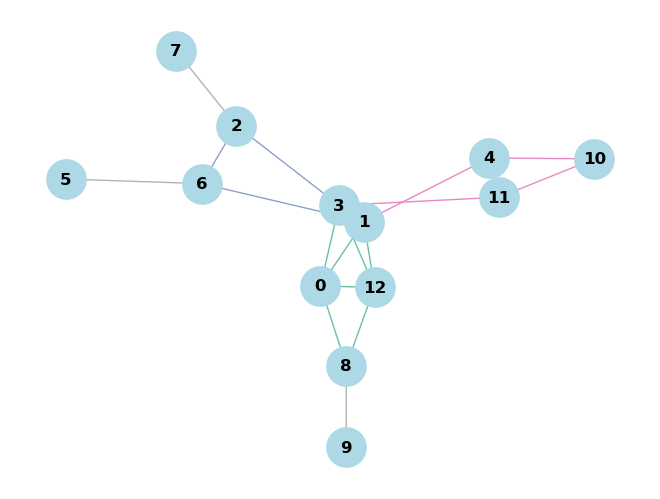

[[0.5   0.5   0.5   0.5   0.444 0.389 0.333 0.278 0.222 0.167 0.111 0.056]
 [0.5   0.5   0.5   0.5   0.444 0.389 0.333 0.278 0.222 0.167 0.111 0.056]
 [0.5   0.5   0.5   0.5   0.444 0.389 0.333 0.278 0.222 0.167 0.111 0.056]
 [0.5   0.5   0.5   0.5   0.444 0.389 0.333 0.278 0.222 0.167 0.111 0.056]
 [0.5   0.5   0.5   0.5   0.444 0.389 0.333 0.278 0.222 0.167 0.111 0.056]
 [0.5   0.5   0.5   0.5   0.444 0.389 0.333 0.278 0.222 0.167 0.111 0.056]
 [0.5   0.5   0.5   0.5   0.444 0.389 0.333 0.278 0.222 0.167 0.111 0.056]
 [0.5   0.5   0.5   0.5   0.444 0.389 0.333 0.278 0.222 0.167 0.111 0.056]
 [0.667 0.667 0.6   0.5   0.444 0.389 0.333 0.278 0.222 0.167 0.111 0.056]
 [0.667 0.667 0.6   0.5   0.444 0.389 0.333 0.278 0.222 0.167 0.111 0.056]
 [0.667 0.667 0.6   0.5   0.444 0.389 0.333 0.278 0.222 0.167 0.111 0.056]
 [0.75  0.714 0.6   0.5   0.444 0.389 0.333 0.278 0.222 0.167 0.111 0.056]
 [0.75  0.714 0.6   0.5   0.444 0.389 0.333 0.278 0.222 0.167 0.111 0.056]
 [0.75  0.714 0.6   0.5  

In [22]:

#Apr 17
#print eta

import networkx as nx
import matplotlib.pyplot as plt

# Create a connected, non-regular graph with 6 vertices
G = nx.Graph()

# Add irregular edges within cluster 1
G.add_edges_from([
    (0, 1), (0,3),(2,3),(1,4),(7,2),(0,8),(8,9),(10,11),(11,3),
    (3,12),(8,12),(4,10),(5,6),(1,3),(6,2),(6,1),(0,12),(1,12)
])
# Visualize the graph
pos = nx.spring_layout(G, seed=42)
# Compute the table
table, index = compute_eta_table_sorted_with_index_table(G)
# Draw the graph
n = len(G.nodes())
m=len(G.edges())
mst = MinimumTEdgeForest(G, n-1)
mod, cons, rho, lam = modulus(m, matrix_modulus, mst,tol = 1e-5, max_iter=1000)
eta = rho / mod
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=800, font_weight='bold',edge_color=np.round(rho,3), edge_cmap=plt.cm.Set2)
plt.show()
# Display
print(table)
print(m)
print(n)
print(index)




In [23]:
compute_balancity_and_eta_star(np.sort(np.round(eta,4)))


η*_{i,j} Table:
     j=0    j=1    j=2    j=3    j=4    j=5    j=6    j=7    j=8  j=9  j=10   j=11   j=12
i=0  0.0  0.056  0.111  0.167  0.222  0.278  0.333  0.389  0.444  0.5   0.5  0.500  0.500
i=1  0.0  0.056  0.111  0.167  0.222  0.278  0.333  0.389  0.444  0.5   0.6  0.667  0.667
i=2  0.0  0.056  0.111  0.167  0.222  0.278  0.333  0.389  0.444  0.5   0.6  0.714  0.750
i=3  0.0  0.056  0.111  0.167  0.222  0.278  0.333  0.389  0.444  0.5   0.6  0.714  1.000


{'unique_eta': array([0.5   , 0.6667, 0.75  , 1.    ]),
 'A_sets': [array([0, 1, 2, 3, 4, 5, 6, 7]),
  array([ 8,  9, 10]),
  array([11, 12, 13, 14]),
  array([15, 16, 17])],
 'E_sets': [array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17]),
  array([ 8,  9, 10, 11, 12, 13, 14, 15, 16, 17]),
  array([11, 12, 13, 14, 15, 16, 17]),
  array([15, 16, 17])],
 'b': [9, 6, 5, 3],
 'c': [0, 9, 10.0, 11.0, 12.0],
 'eta_star_matrix': array([[0.        , 0.05555556, 0.11111111, 0.16666667, 0.22222222,
         0.27777778, 0.33333333, 0.38888889, 0.44444444, 0.5       ,
         0.5       , 0.5       , 0.5       ],
        [0.        , 0.05555556, 0.11111111, 0.16666667, 0.22222222,
         0.27777778, 0.33333333, 0.38888889, 0.44444444, 0.5       ,
         0.6       , 0.6667    , 0.6667    ],
        [0.        , 0.05555556, 0.11111111, 0.16666667, 0.22222222,
         0.27777778, 0.33333333, 0.38888889, 0.44444444, 0.5       ,
         0.6       , 0.71428571,

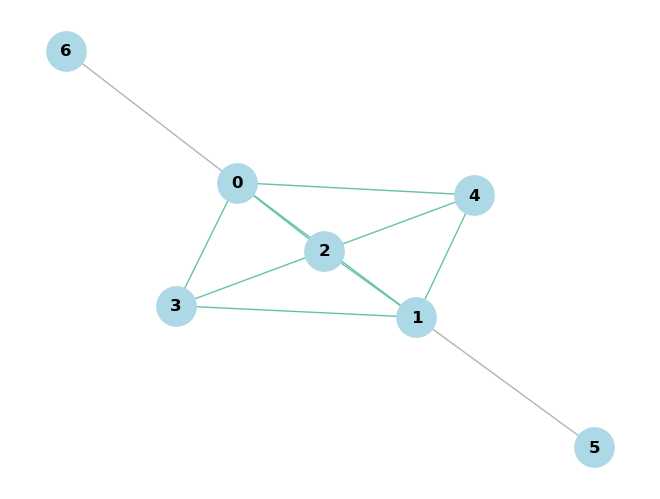

[[0.444 0.444 0.364 0.273 0.182 0.091]
 [0.444 0.444 0.364 0.273 0.182 0.091]
 [0.444 0.444 0.364 0.273 0.182 0.091]
 [0.444 0.444 0.364 0.273 0.182 0.091]
 [0.444 0.444 0.364 0.273 0.182 0.091]
 [0.444 0.444 0.364 0.273 0.182 0.091]
 [0.444 0.444 0.364 0.273 0.182 0.091]
 [0.444 0.444 0.364 0.273 0.182 0.091]
 [0.444 0.444 0.364 0.273 0.182 0.091]
 [1.    0.5   0.364 0.273 0.182 0.091]
 [1.    0.5   0.364 0.273 0.182 0.091]]
11
7
[[ 0  0  0  0  0  0]
 [ 1  1  1  1  1  1]
 [ 2  2  2  2  2  2]
 [ 3  3  3  3  3  3]
 [ 5  5  4  4  4  4]
 [ 6  6  5  5  5  5]
 [ 7  7  6  6  6  6]
 [ 9  9  7  7  7  7]
 [10 10  8  8  8  8]
 [ 4  4  9  9  9  9]
 [ 8  8 10 10 10 10]]

η*_{i,j} Table:
     j=0    j=1    j=2    j=3    j=4    j=5    j=6
i=0  0.0  0.091  0.182  0.273  0.364  0.444  0.444
i=1  0.0  0.091  0.182  0.273  0.364  0.500  1.000


{'unique_eta': array([0.4444, 1.    ]),
 'A_sets': [array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([ 9, 10])],
 'E_sets': [array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
  array([ 9, 10])],
 'b': [4, 2],
 'c': [0, 4, 6.0],
 'eta_star_matrix': array([[0.        , 0.09090909, 0.18181818, 0.27272727, 0.36363636,
         0.4444    , 0.4444    ],
        [0.        , 0.09090909, 0.18181818, 0.27272727, 0.36363636,
         0.5       , 1.        ]])}

In [24]:



#Apr 17
#print eta

import networkx as nx
import matplotlib.pyplot as plt

# Create a connected, non-regular graph with 6 vertices
G = nx.Graph()

# Add irregular edges within cluster 1
G.add_edges_from([
   (0, 1), (0, 2), (0, 3), (0, 4), (0, 6), (1, 2), (1, 3), (1, 4), (1, 5), (2, 3), (2, 4)
])
# Visualize the graph
pos = nx.spring_layout(G, seed=42)
# Compute the table
table, index = compute_eta_table_sorted_with_index_table(G)
# Draw the graph
n = len(G.nodes())
m=len(G.edges())
mst = MinimumTEdgeForest(G, n-1)
mod, cons, rho, lam = modulus(m, matrix_modulus, mst,tol = 1e-5, max_iter=1000)
eta = rho / mod
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=800, font_weight='bold',edge_color=np.round(rho,3), edge_cmap=plt.cm.Set2)
plt.show()
# Display
print(table)
print(m)
print(n)
print(index)

compute_balancity_and_eta_star(np.sort(np.round(eta,4)))


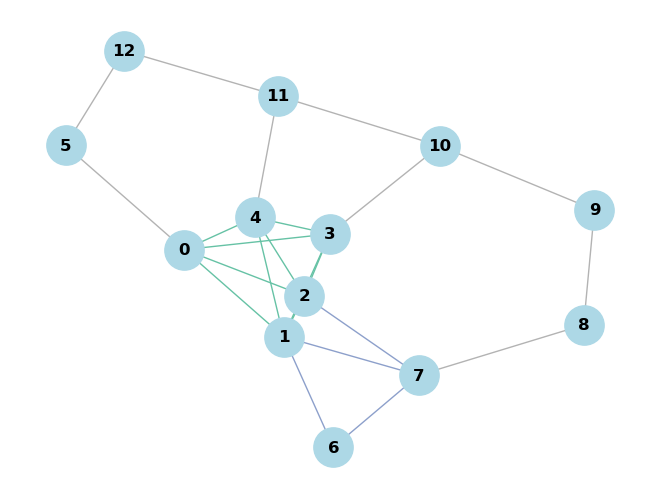

[[0.4   0.4   0.4   0.391 0.348 0.304 0.261 0.217 0.174 0.13  0.087 0.043]
 [0.4   0.4   0.4   0.391 0.348 0.304 0.261 0.217 0.174 0.13  0.087 0.043]
 [0.4   0.4   0.4   0.391 0.348 0.304 0.261 0.217 0.174 0.13  0.087 0.043]
 [0.4   0.4   0.4   0.391 0.348 0.304 0.261 0.217 0.174 0.13  0.087 0.043]
 [0.4   0.4   0.4   0.391 0.348 0.304 0.261 0.217 0.174 0.13  0.087 0.043]
 [0.4   0.4   0.4   0.391 0.348 0.304 0.261 0.217 0.174 0.13  0.087 0.043]
 [0.4   0.4   0.4   0.391 0.348 0.304 0.261 0.217 0.174 0.13  0.087 0.043]
 [0.4   0.4   0.4   0.391 0.348 0.304 0.261 0.217 0.174 0.13  0.087 0.043]
 [0.4   0.4   0.4   0.391 0.348 0.304 0.261 0.217 0.174 0.13  0.087 0.043]
 [0.4   0.4   0.4   0.391 0.348 0.304 0.261 0.217 0.174 0.13  0.087 0.043]
 [0.5   0.5   0.462 0.391 0.348 0.304 0.261 0.217 0.174 0.13  0.087 0.043]
 [0.5   0.5   0.462 0.391 0.348 0.304 0.261 0.217 0.174 0.13  0.087 0.043]
 [0.5   0.5   0.462 0.391 0.348 0.304 0.261 0.217 0.174 0.13  0.087 0.043]
 [0.5   0.5   0.462 0.391

In [68]:
# algorithm to use the matrix from eta^*

#Apr 17
#print eta

import networkx as nx
import matplotlib.pyplot as plt

# Create a connected, non-regular graph with 6 vertices
G = nx.Graph()

# Add irregular edges within cluster 1
G.add_edges_from([(0,1),(0,2),(0,3),(0,4),(1,2),(1,3),(1,4),(2,3),(2,4),(3,4),(6,7),(7,8),(8,9),(9,10),(10,11),(11,12),(12,5),
                  (0,5),(1,6),(2,7),(3,10),(4,11),(1,7)
])
# Visualize the graph
pos = nx.spring_layout(G, seed=38)
# Compute the table
table, index = compute_eta_table_sorted_with_index_table(G)
# Draw the graph
n = len(G.nodes())
m=len(G.edges())
mst = MinimumTEdgeForest(G, n-1)
mod, cons, rho, lam = modulus(m, matrix_modulus, mst,tol = 1e-5, max_iter=1000)
eta = rho / mod
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=800, font_weight='bold',edge_color=np.round(rho,3), edge_cmap=plt.cm.Set2)
plt.show()
# Display
print(table)
print(m)
print(n)
print(index)




In [ ]:
# NEXT DO THE DUAL

In [70]:
compute_balancity_and_eta_star(np.sort(np.round(eta,4)))
results = compute_balancity_and_eta_star(np.sort(1 - np.round(eta, 4)))
eta_star_matrix = results["eta_star_matrix"]
print_eta_star_table(np.sort(1-eta_star_matrix,0))
compute_balancity_and_eta_star(np.sort( np.round(eta, 4)))


η*_{i,j} Table:
     j=0    j=1    j=2   j=3    j=4    j=5    j=6    j=7    j=8    j=9   j=10   j=11   j=12
i=0  0.0  0.043  0.087  0.13  0.174  0.217  0.261  0.304  0.348  0.391  0.400  0.400  0.400
i=1  0.0  0.043  0.087  0.13  0.174  0.217  0.261  0.304  0.348  0.391  0.462  0.500  0.500
i=2  0.0  0.043  0.087  0.13  0.174  0.217  0.261  0.304  0.348  0.391  0.462  0.556  0.667

η*_{i,j} Table:
     j=0    j=1    j=2   j=3    j=4    j=5    j=6    j=7    j=8    j=9   j=10   j=11
i=0  0.0  0.043  0.087  0.13  0.174  0.217  0.261  0.304  0.333  0.333  0.333  0.333
i=1  0.0  0.043  0.087  0.13  0.174  0.217  0.261  0.304  0.357  0.429  0.500  0.500
i=2  0.0  0.043  0.087  0.13  0.174  0.217  0.261  0.304  0.357  0.429  0.500  0.600

η*_{i,j} Table:
     j=0     j=1    j=2     j=3     j=4     j=5     j=6     j=7     j=8     j=9    j=10    j=11
i=0  1.0  0.9565  0.913  0.8696  0.8261  0.7826  0.7391  0.6957  0.6429  0.5714  0.5000  0.4000
i=1  1.0  0.9565  0.913  0.8696  0.8261  0.7826  

{'unique_eta': array([0.4   , 0.5   , 0.6667]),
 'A_sets': [array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
  array([10, 11, 12, 13]),
  array([14, 15, 16, 17, 18, 19, 20, 21, 22])],
 'E_sets': [array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19, 20, 21, 22]),
  array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]),
  array([14, 15, 16, 17, 18, 19, 20, 21, 22])],
 'b': [9, 6, 6],
 'c': [0, 9, 10.0, 12.0],
 'eta_star_matrix': array([[0.        , 0.04347826, 0.08695652, 0.13043478, 0.17391304,
         0.2173913 , 0.26086957, 0.30434783, 0.34782609, 0.39130435,
         0.4       , 0.4       , 0.4       ],
        [0.        , 0.04347826, 0.08695652, 0.13043478, 0.17391304,
         0.2173913 , 0.26086957, 0.30434783, 0.34782609, 0.39130435,
         0.46153846, 0.5       , 0.5       ],
        [0.        , 0.04347826, 0.08695652, 0.13043478, 0.17391304,
         0.2173913 , 0.26086957, 0.30434783, 0.34782609, 0.39130435,
         0.46153846, 0.55

In [71]:
16/23

0.6956521739130435

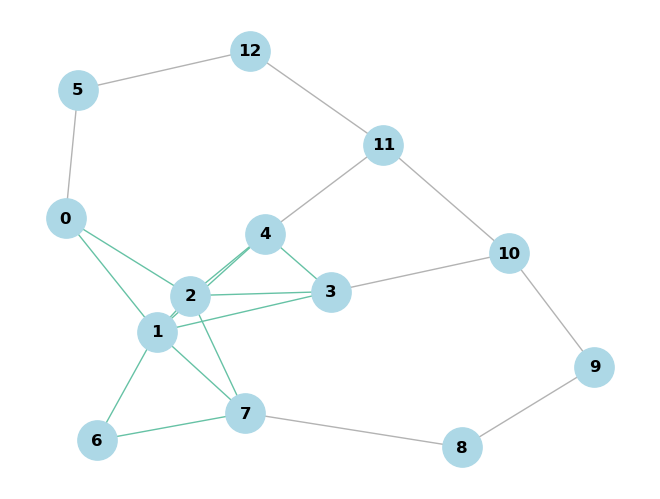

[[0.5   0.5   0.476 0.429 0.381 0.333 0.286 0.238 0.19  0.143 0.095 0.048]
 [0.5   0.5   0.476 0.429 0.381 0.333 0.286 0.238 0.19  0.143 0.095 0.048]
 [0.5   0.5   0.476 0.429 0.381 0.333 0.286 0.238 0.19  0.143 0.095 0.048]
 [0.5   0.5   0.476 0.429 0.381 0.333 0.286 0.238 0.19  0.143 0.095 0.048]
 [0.5   0.5   0.476 0.429 0.381 0.333 0.286 0.238 0.19  0.143 0.095 0.048]
 [0.5   0.5   0.476 0.429 0.381 0.333 0.286 0.238 0.19  0.143 0.095 0.048]
 [0.5   0.5   0.476 0.429 0.381 0.333 0.286 0.238 0.19  0.143 0.095 0.048]
 [0.5   0.5   0.476 0.429 0.381 0.333 0.286 0.238 0.19  0.143 0.095 0.048]
 [0.5   0.5   0.476 0.429 0.381 0.333 0.286 0.238 0.19  0.143 0.095 0.048]
 [0.5   0.5   0.476 0.429 0.381 0.333 0.286 0.238 0.19  0.143 0.095 0.048]
 [0.5   0.5   0.476 0.429 0.381 0.333 0.286 0.238 0.19  0.143 0.095 0.048]
 [0.5   0.5   0.476 0.429 0.381 0.333 0.286 0.238 0.19  0.143 0.095 0.048]
 [0.667 0.556 0.476 0.429 0.381 0.333 0.286 0.238 0.19  0.143 0.095 0.048]
 [0.667 0.556 0.476 0.429

{'unique_eta': array([0.5   , 0.6667]),
 'A_sets': [array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
  array([12, 13, 14, 15, 16, 17, 18, 19, 20])],
 'E_sets': [array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19, 20]),
  array([12, 13, 14, 15, 16, 17, 18, 19, 20])],
 'b': [10, 6],
 'c': [0, 10, 12.0],
 'eta_star_matrix': array([[0.        , 0.04761905, 0.0952381 , 0.14285714, 0.19047619,
         0.23809524, 0.28571429, 0.33333333, 0.38095238, 0.42857143,
         0.47619048, 0.5       , 0.5       ],
        [0.        , 0.04761905, 0.0952381 , 0.14285714, 0.19047619,
         0.23809524, 0.28571429, 0.33333333, 0.38095238, 0.42857143,
         0.47619048, 0.55555556, 0.66666667]])}

In [16]:
# algorithm to use the matrix from eta^*

#Apr 17
#print eta

import networkx as nx
import matplotlib.pyplot as plt

# Create a connected, non-regular graph with 6 vertices
G = nx.Graph()

# Add irregular edges within cluster 1
G.add_edges_from([(0,1),(0,2),(1,2),(1,3),(1,4),(2,3),(2,4),(3,4),(6,7),(7,8),(8,9),(9,10),(10,11),(11,12),(12,5),
                  (0,5),(1,6),(2,7),(3,10),(4,11),(1,7)
])
# Visualize the graph
pos = nx.spring_layout(G, seed=38)
# Compute the table
table, index = compute_eta_table_sorted_with_index_table(G)
# Draw the graph
n = len(G.nodes())
m=len(G.edges())
mst = MinimumTEdgeForest(G, n-1)
mod, cons, rho, lam = modulus(m, matrix_modulus, mst,tol = 1e-5, max_iter=1000)
eta = rho / mod
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=800, font_weight='bold',edge_color=np.round(rho,3), edge_cmap=plt.cm.Set2)
plt.show()
# Display
print(table)
print(m)
print(n)
print(index)

compute_balancity_and_eta_star(np.sort(np.round(eta,4)))


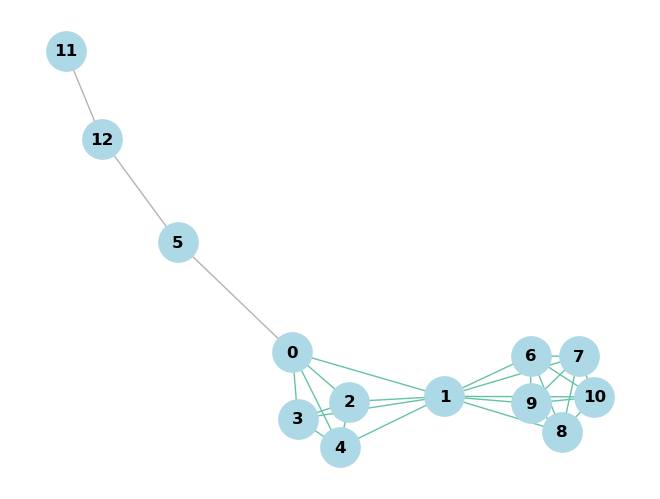

[[0.333 0.333 0.333 0.321 0.286 0.25  0.214 0.179 0.143 0.107 0.071 0.036]
 [0.333 0.333 0.333 0.321 0.286 0.25  0.214 0.179 0.143 0.107 0.071 0.036]
 [0.333 0.333 0.333 0.321 0.286 0.25  0.214 0.179 0.143 0.107 0.071 0.036]
 [0.333 0.333 0.333 0.321 0.286 0.25  0.214 0.179 0.143 0.107 0.071 0.036]
 [0.333 0.333 0.333 0.321 0.286 0.25  0.214 0.179 0.143 0.107 0.071 0.036]
 [0.333 0.333 0.333 0.321 0.286 0.25  0.214 0.179 0.143 0.107 0.071 0.036]
 [0.333 0.333 0.333 0.321 0.286 0.25  0.214 0.179 0.143 0.107 0.071 0.036]
 [0.333 0.333 0.333 0.321 0.286 0.25  0.214 0.179 0.143 0.107 0.071 0.036]
 [0.333 0.333 0.333 0.321 0.286 0.25  0.214 0.179 0.143 0.107 0.071 0.036]
 [0.333 0.333 0.333 0.321 0.286 0.25  0.214 0.179 0.143 0.107 0.071 0.036]
 [0.333 0.333 0.333 0.321 0.286 0.25  0.214 0.179 0.143 0.107 0.071 0.036]
 [0.333 0.333 0.333 0.321 0.286 0.25  0.214 0.179 0.143 0.107 0.071 0.036]
 [0.333 0.333 0.333 0.321 0.286 0.25  0.214 0.179 0.143 0.107 0.071 0.036]
 [0.333 0.333 0.333 0.321

{'unique_eta': array([0.3333, 0.4   , 1.    ]),
 'A_sets': [array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
  array([15, 16, 17, 18, 19, 20, 21, 22, 23, 24]),
  array([25, 26, 27])],
 'E_sets': [array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]),
  array([15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]),
  array([25, 26, 27])],
 'b': [9, 5, 3],
 'c': [0, 9, 10.0, 12.0],
 'eta_star_matrix': array([[0.        , 0.03571429, 0.07142857, 0.10714286, 0.14285714,
         0.17857143, 0.21428571, 0.25      , 0.28571429, 0.32142857,
         0.3333    , 0.3333    , 0.3333    ],
        [0.        , 0.03571429, 0.07142857, 0.10714286, 0.14285714,
         0.17857143, 0.21428571, 0.25      , 0.28571429, 0.32142857,
         0.38461538, 0.4       , 0.4       ],
        [0.        , 0.03571429, 0.07142857, 0.10714286, 0.14285714,
         0.17857143, 0.21428571, 0.25      , 0.28571429, 0.32142857,

In [23]:
# algorithm to use the matrix from eta^*

#Apr 17
#print eta

import networkx as nx
import matplotlib.pyplot as plt

# Create a connected, non-regular graph with 6 vertices
G = nx.Graph()

# Add irregular edges within cluster 1
G.add_edges_from([(0,1),(0,2),(1,2),(0,3),(0,4),(1,3),(1,4),(2,3),(2,4),(3,4),(6,7),(7,8),(8,9),(9,10),(11,12),(12,5),
                  (0,5),(1,6),(1,7),(1,8),(6,8),(9,1),(9,6),(9,7),(10,1),(10,6),(10,7),(10,8)
])
# Visualize the graph
pos = nx.spring_layout(G, seed=38)
# Compute the table
table, index = compute_eta_table_sorted_with_index_table(G)
# Draw the graph
n = len(G.nodes())
m=len(G.edges())
mst = MinimumTEdgeForest(G, n-1)
mod, cons, rho, lam = modulus(m, matrix_modulus, mst,tol = 1e-5, max_iter=1000)
eta = rho / mod
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=800, font_weight='bold',edge_color=np.round(rho,3), edge_cmap=plt.cm.Set2)
plt.show()
# Display
print(table)
print(m)
print(n)
print(index)

compute_balancity_and_eta_star(np.sort(np.round(eta,4)))


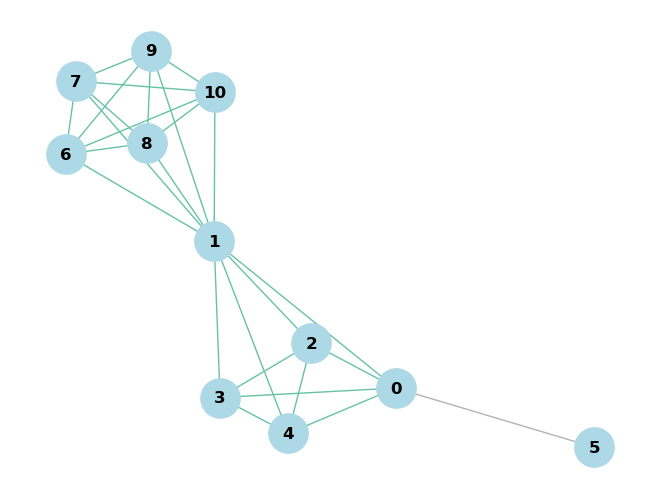

[[0.333 0.333 0.308 0.269 0.231 0.192 0.154 0.115 0.077 0.038]
 [0.333 0.333 0.308 0.269 0.231 0.192 0.154 0.115 0.077 0.038]
 [0.333 0.333 0.308 0.269 0.231 0.192 0.154 0.115 0.077 0.038]
 [0.333 0.333 0.308 0.269 0.231 0.192 0.154 0.115 0.077 0.038]
 [0.333 0.333 0.308 0.269 0.231 0.192 0.154 0.115 0.077 0.038]
 [0.333 0.333 0.308 0.269 0.231 0.192 0.154 0.115 0.077 0.038]
 [0.333 0.333 0.308 0.269 0.231 0.192 0.154 0.115 0.077 0.038]
 [0.333 0.333 0.308 0.269 0.231 0.192 0.154 0.115 0.077 0.038]
 [0.333 0.333 0.308 0.269 0.231 0.192 0.154 0.115 0.077 0.038]
 [0.333 0.333 0.308 0.269 0.231 0.192 0.154 0.115 0.077 0.038]
 [0.333 0.333 0.308 0.269 0.231 0.192 0.154 0.115 0.077 0.038]
 [0.333 0.333 0.308 0.269 0.231 0.192 0.154 0.115 0.077 0.038]
 [0.333 0.333 0.308 0.269 0.231 0.192 0.154 0.115 0.077 0.038]
 [0.333 0.333 0.308 0.269 0.231 0.192 0.154 0.115 0.077 0.038]
 [0.333 0.333 0.308 0.269 0.231 0.192 0.154 0.115 0.077 0.038]
 [0.4   0.364 0.308 0.269 0.231 0.192 0.154 0.115 0.077

{'unique_eta': array([0.3333, 0.4   , 1.    ]),
 'A_sets': [array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
  array([15, 16, 17, 18, 19, 20, 21, 22, 23, 24]),
  array([25])],
 'E_sets': [array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19, 20, 21, 22, 23, 24, 25]),
  array([15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]),
  array([25])],
 'b': [8, 4, 1],
 'c': [0, 8, 9.0, 10.0],
 'eta_star_matrix': array([[0.        , 0.03846154, 0.07692308, 0.11538462, 0.15384615,
         0.19230769, 0.23076923, 0.26923077, 0.30769231, 0.3333    ,
         0.3333    ],
        [0.        , 0.03846154, 0.07692308, 0.11538462, 0.15384615,
         0.19230769, 0.23076923, 0.26923077, 0.30769231, 0.36363636,
         0.4       ],
        [0.        , 0.03846154, 0.07692308, 0.11538462, 0.15384615,
         0.19230769, 0.23076923, 0.26923077, 0.30769231, 0.36363636,
         1.        ]])}

In [25]:
# algorithm to use the matrix from eta^*

#Apr 17
#print eta

import networkx as nx
import matplotlib.pyplot as plt

# Create a connected, non-regular graph with 6 vertices
G = nx.Graph()

# Add irregular edges within cluster 1
G.add_edges_from([(0,1),(0,2),(1,2),(0,3),(0,4),(1,3),(1,4),(2,3),(2,4),(3,4),(6,7),(7,8),(8,9),(9,10),
                  (0,5),(1,6),(1,7),(1,8),(6,8),(9,1),(9,6),(9,7),(10,1),(10,6),(10,7),(10,8)
])
# Visualize the graph
pos = nx.spring_layout(G, seed=38)
# Compute the table
table, index = compute_eta_table_sorted_with_index_table(G)
# Draw the graph
n = len(G.nodes())
m=len(G.edges())
mst = MinimumTEdgeForest(G, n-1)
mod, cons, rho, lam = modulus(m, matrix_modulus, mst,tol = 1e-5, max_iter=1000)
eta = rho / mod
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=800, font_weight='bold',edge_color=np.round(rho,3), edge_cmap=plt.cm.Set2)
plt.show()
# Display
print(table)
print(m)
print(n)
print(index)

compute_balancity_and_eta_star(np.sort(np.round(eta,4)))


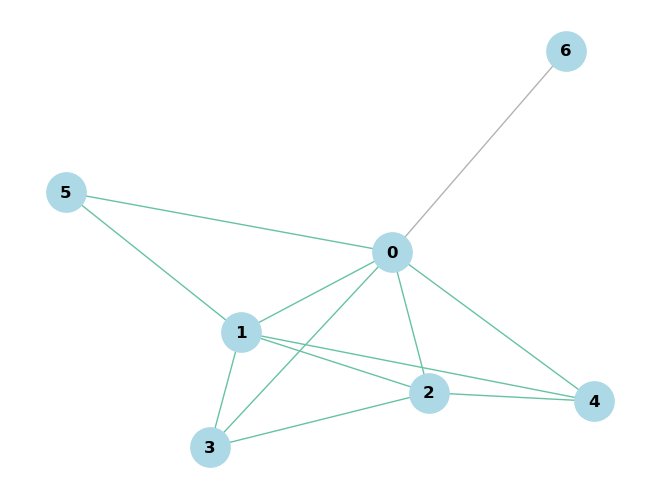

[[0.444 0.417 0.333 0.25  0.167 0.083]
 [0.444 0.417 0.333 0.25  0.167 0.083]
 [0.444 0.417 0.333 0.25  0.167 0.083]
 [0.444 0.417 0.333 0.25  0.167 0.083]
 [0.444 0.417 0.333 0.25  0.167 0.083]
 [0.444 0.417 0.333 0.25  0.167 0.083]
 [0.444 0.417 0.333 0.25  0.167 0.083]
 [0.444 0.417 0.333 0.25  0.167 0.083]
 [0.444 0.417 0.333 0.25  0.167 0.083]
 [0.5   0.417 0.333 0.25  0.167 0.083]
 [0.5   0.417 0.333 0.25  0.167 0.083]
 [1.    0.417 0.333 0.25  0.167 0.083]]
12
7
[[ 0  0  0  0  0  0]
 [ 1  1  1  1  1  1]
 [ 2  2  2  2  2  2]
 [ 3  3  3  3  3  3]
 [ 6  4  4  4  4  4]
 [ 7  5  5  5  5  5]
 [ 8  6  6  6  6  6]
 [10  7  7  7  7  7]
 [11  8  8  8  8  8]
 [ 4  9  9  9  9  9]
 [ 9 10 10 10 10 10]
 [ 5 11 11 11 11 11]]

η*_{i,j} Table:
     j=0    j=1    j=2   j=3    j=4    j=5    j=6
i=0  0.0  0.083  0.167  0.25  0.333  0.417  0.444
i=1  0.0  0.083  0.167  0.25  0.333  0.417  0.500
i=2  0.0  0.083  0.167  0.25  0.333  0.417  1.000


{'unique_eta': array([0.4444, 0.5   , 1.    ]),
 'A_sets': [array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([ 9, 10]), array([11])],
 'E_sets': [array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
  array([ 9, 10, 11]),
  array([11])],
 'b': [5, 1, 1],
 'c': [0, 5, 5.0, 6.0],
 'eta_star_matrix': array([[0.        , 0.08333333, 0.16666667, 0.25      , 0.33333333,
         0.41666667, 0.4444    ],
        [0.        , 0.08333333, 0.16666667, 0.25      , 0.33333333,
         0.41666667, 0.5       ],
        [0.        , 0.08333333, 0.16666667, 0.25      , 0.33333333,
         0.41666667, 1.        ]])}

In [25]:

# algorithm to use the matrix from eta^*

#Apr 17
#print eta

import networkx as nx
import matplotlib.pyplot as plt

# Create a connected, non-regular graph with 6 vertices
G = nx.Graph()

# Add irregular edes within cluster 1
G.add_edges_from([(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 2), (1, 3), (1, 4), (1, 5), (2, 3), (2, 4)
])
# Visualize the graph
pos = nx.spring_layout(G, seed=38)
# Compute the table
table, index = compute_eta_table_sorted_with_index_table(G)
# Draw the graph
n = len(G.nodes())
m=len(G.edges())
mst = MinimumTEdgeForest(G, n-1)
mod, cons, rho, lam = modulus(m, matrix_modulus, mst,tol = 1e-5, max_iter=1000)
eta = rho / mod
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=800, font_weight='bold',edge_color=np.round(rho,3), edge_cmap=plt.cm.Set2)
plt.show()
# Display
print(table)
print(m)
print(n)
print(index)

compute_balancity_and_eta_star(np.sort(np.round(eta,4)))


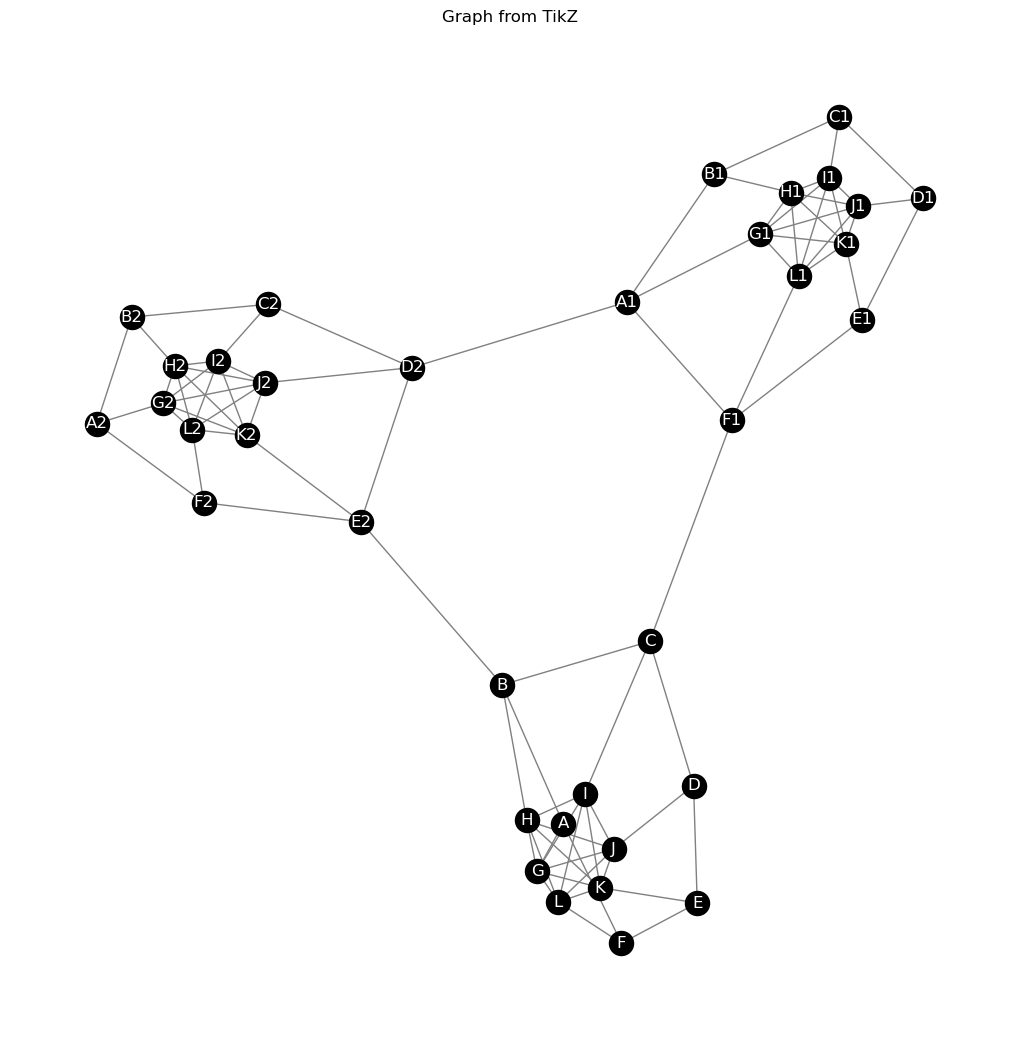

84

In [28]:
# JULY 30
import networkx as nx
import matplotlib.pyplot as plt

# Create an undirected graph
G = nx.Graph()

# Define node groups
core_nodes = ['G', 'H', 'I', 'J', 'K', 'L']
core_nodes1 = [n + '1' for n in core_nodes]
core_nodes2 = [n + '2' for n in core_nodes]

outer_nodes = ['A', 'B', 'C', 'D', 'E', 'F']
outer_nodes1 = [n + '1' for n in outer_nodes]
outer_nodes2 = [n + '2' for n in outer_nodes]

# Add all nodes
G.add_nodes_from(core_nodes + core_nodes1 + core_nodes2 + outer_nodes + outer_nodes1 + outer_nodes2)

# Define helper to add hexagonal and core internal edges
def add_hexagon_and_core_edges(core, outer):
    # Hexagon ring
    G.add_edges_from([(core[0], core[1]), (core[1], core[2]), (core[2], core[3]),
                      (core[3], core[4]), (core[4], core[5]), (core[5], core[0])])

    # Core connections (triangle-like)
    G.add_edges_from([(core[0], core[2]), (core[0], core[3]), (core[0], core[4]),
                      (core[1], core[3]), (core[1], core[4]), (core[1], core[5]),
                      (core[2], core[4]), (core[2], core[5]), (core[3], core[5])])

    # Outer to core dashed connections
    G.add_edges_from([(outer[0], core[0]), (outer[1], core[1]), (outer[2], core[2]),
                      (outer[3], core[3]), (outer[4], core[4]), (outer[5], core[5])])

    # Outer ring
    G.add_edges_from([(outer[0], outer[1]), (outer[1], outer[2]), (outer[2], outer[3]),
                      (outer[3], outer[4]), (outer[4], outer[5]), (outer[5], outer[0])])

# Add main hexagon + inner-core edges for each group
add_hexagon_and_core_edges(core_nodes, outer_nodes)
add_hexagon_and_core_edges(core_nodes1, outer_nodes1)
add_hexagon_and_core_edges(core_nodes2, outer_nodes2)

# Add cross dotted connections (between different groups)
G.add_edges_from([
    ('C', 'F1'),
    ('B', 'E2'),
    ('D2', 'A1')
])

# Draw the graph
plt.figure(figsize=(10, 10))
nx.draw(G, with_labels=True, node_color='black', node_size=300, font_color='white', edge_color='gray')
plt.title("Graph from TikZ")
plt.show()
len(G.edges())


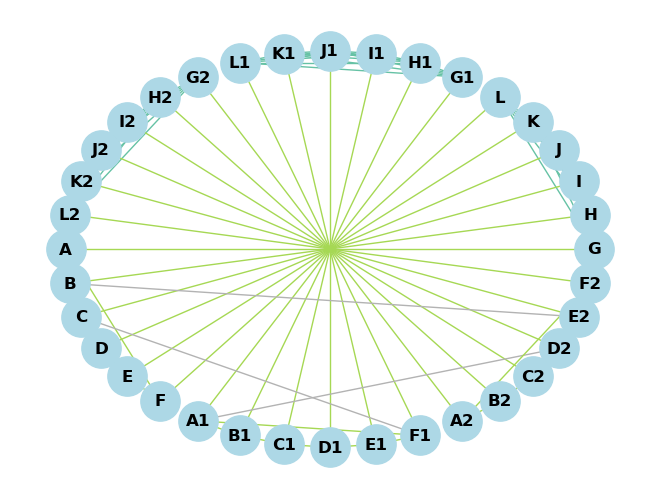

[[0.333 0.333 0.333 ... 0.036 0.024 0.012]
 [0.333 0.333 0.333 ... 0.036 0.024 0.012]
 [0.333 0.333 0.333 ... 0.036 0.024 0.012]
 ...
 [0.667 0.487 0.462 ... 0.036 0.024 0.012]
 [0.667 0.487 0.462 ... 0.036 0.024 0.012]
 [0.667 0.487 0.462 ... 0.036 0.024 0.012]]
84
36
[[ 0  0  0 ...  0  0  0]
 [ 1  1  1 ...  1  1  1]
 [ 2  2  2 ...  2  2  2]
 ...
 [66 81 81 ... 81 81 81]
 [68 82 82 ... 82 82 82]
 [73 83 83 ... 83 83 83]]

η*_{i,j} Table:
     j=0    j=1    j=2    j=3    j=4   j=5    j=6    j=7    j=8    j=9   j=10   j=11   j=12   j=13   j=14   j=15  j=16   j=17   j=18   j=19   j=20  j=21   j=22   j=23   j=24   j=25  j=26   j=27   j=28   j=29   j=30   j=31   j=32   j=33   j=34   j=35
i=0  0.0  0.012  0.024  0.036  0.048  0.06  0.071  0.083  0.095  0.107  0.119  0.131  0.143  0.155  0.167  0.179  0.19  0.202  0.214  0.226  0.238  0.25  0.262  0.274  0.286  0.298  0.31  0.321  0.333  0.333  0.333  0.333  0.333  0.333  0.333  0.333
i=1  0.0  0.012  0.024  0.036  0.048  0.06  0.071  0.083 

{'unique_eta': array([0.3333, 0.5   , 0.6667]),
 'A_sets': [array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
         34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]),
  array([45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61,
         62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78,
         79, 80]),
  array([81, 82, 83])],
 'E_sets': [array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
         34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
         51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
         68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83]),
  array([45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61,
         62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 7

In [31]:
# Compute the table
pos = nx.circular_layout(G)
table, index = compute_eta_table_sorted_with_index_table(G)
# Draw the graph
n = len(G.nodes())
m=len(G.edges())
mst = MinimumTEdgeForest(G, n-1)
mod, cons, rho, lam = modulus(m, matrix_modulus, mst,tol = 1e-5, max_iter=1000)
eta = rho / mod
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=800, font_weight='bold',edge_color=np.round(rho,3), edge_cmap=plt.cm.Set2)
plt.show()
# Display
print(table)
print(m)
print(n)
print(index)
#USE ALGORITHM TO COMPUTE ALL ETA HERE
compute_balancity_and_eta_star(np.sort(np.round(eta,4)))


In [ ]:
# how to compute the extended matrix?



In [15]:
import numpy as np

v = np.concatenate([
    np.full(45, 1/3),
    np.full(36, 1/2),
    np.full(3, 2/3)
])

print(v)

compute_balancity_and_eta_star(np.sort(v))

[0.33333333 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333
 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333
 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333
 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333
 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333
 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333
 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333
 0.33333333 0.33333333 0.33333333 0.5        0.5        0.5
 0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5        0.66666667 0.66666667 0.66666667]

η*_{i,j} Table:
     j=0    j=1    j=2    j=3    j=4   j=5    j=6    j=7    j=8    j=9   j=10   j=11  

{'unique_eta': array([0.33333333, 0.5       , 0.66666667]),
 'A_sets': [array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
         34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]),
  array([45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61,
         62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78,
         79, 80]),
  array([81, 82, 83])],
 'E_sets': [array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
         34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
         51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
         68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83]),
  array([45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61,
         62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 7

In [18]:
compute_balancity_and_eta_star(np.sort(1-v))


η*_{i,j} Table:
     j=0    j=1    j=2    j=3    j=4   j=5    j=6    j=7    j=8    j=9   j=10   j=11   j=12   j=13   j=14   j=15  j=16   j=17   j=18   j=19   j=20  j=21   j=22   j=23   j=24   j=25  j=26   j=27   j=28   j=29   j=30   j=31   j=32   j=33   j=34   j=35   j=36   j=37   j=38   j=39   j=40   j=41   j=42   j=43   j=44   j=45   j=46   j=47   j=48   j=49
i=0  0.0  0.012  0.024  0.036  0.048  0.06  0.071  0.083  0.095  0.107  0.119  0.131  0.143  0.155  0.167  0.179  0.19  0.202  0.214  0.226  0.238  0.25  0.262  0.274  0.286  0.298  0.31  0.321  0.333  0.333  0.333  0.333  0.333  0.333  0.333  0.333  0.333  0.333  0.333  0.333  0.333  0.333  0.333  0.333  0.333  0.333  0.333  0.333  0.333  0.333
i=1  0.0  0.012  0.024  0.036  0.048  0.06  0.071  0.083  0.095  0.107  0.119  0.131  0.143  0.155  0.167  0.179  0.19  0.202  0.214  0.226  0.238  0.25  0.262  0.274  0.286  0.298  0.31  0.321  0.333  0.346  0.358  0.370  0.383  0.395  0.407  0.420  0.432  0.444  0.457  0.469  0.481  0

{'unique_eta': array([0.33333333, 0.5       , 0.66666667]),
 'A_sets': [array([0, 1, 2]),
  array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
         20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
         37, 38]),
  array([39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55,
         56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72,
         73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83])],
 'E_sets': [array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
         34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
         51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
         68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83]),
  array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
         20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 

In [17]:
1 -np.sort(v)

array([0.66666667, 0.66666667, 0.66666667, 0.66666667, 0.66666667,
       0.66666667, 0.66666667, 0.66666667, 0.66666667, 0.66666667,
       0.66666667, 0.66666667, 0.66666667, 0.66666667, 0.66666667,
       0.66666667, 0.66666667, 0.66666667, 0.66666667, 0.66666667,
       0.66666667, 0.66666667, 0.66666667, 0.66666667, 0.66666667,
       0.66666667, 0.66666667, 0.66666667, 0.66666667, 0.66666667,
       0.66666667, 0.66666667, 0.66666667, 0.66666667, 0.66666667,
       0.66666667, 0.66666667, 0.66666667, 0.66666667, 0.66666667,
       0.66666667, 0.66666667, 0.66666667, 0.66666667, 0.66666667,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5    